# Group comparison 3T and 7T epilepsy  

Surface-based comparisons  
- vertex-wise T-test : are controls and pts different?
- vertex-wise effect size : how big are the distances between the vertex differences?
    - Use own function


For figures: 
- Visualize effect size on a brain masked for significant p-values 

In [ ]:
import pandas as pd
import numpy as np
import nibabel as nib
import pickle
import datetime
import brainstat as bstat
import copy

import importlib
import tTsTGrpUtils as tsutil
import vrtx


In [2]:
importlib.reload(tsutil)
importlib.reload(vrtx)

<module 'vrtx' from '/host/verges/tank/data/daniel/3T7T/z/code/analyses/vrtx.py'>

# MAIN

In [2]:
# specify root directories
MICs = {
    "name": "MICs",
    "dir_root": "/data/mica3/BIDS_MICs",
    "dir_raw": "/rawdata",
    "dir_deriv": "/derivatives",
    "dir_mp": "/micapipe_v0.2.0",
    "dir_hu": "/hippunfold_v1.3.0/hippunfold",
    "dir_zb": "/DM_zb_37comp",
    "study": "3T",
    "ID_ctrl" : ["HC"],
    "ID_Pt" : ["PX"]
    }

PNI = {
    "name": "PNI",
    "dir_root": "/data/mica3/BIDS_PNI",
    "dir_raw": "/rawdata",
    "dir_deriv": "/derivatives",
    "dir_mp": "/micapipe_v0.2.0",
    "dir_hu": "/hippunfold_v1.3.0/hippunfold",
    "dir_zb": "/DM_zb_37comp",
    "study": "7T",
    "ID_col" : ["PNC", "Pilot"], # column for ID in demographics file
    }

studies = [MICs, PNI]

demographics = {
    "pth" : "/host/verges/tank/data/daniel/3T7T/z/data/pt/demo_27Aug2025.csv",
    # column names:
    'nStudies': True, # whether multiple studies are included
    "ID_7T" : "PNI_ID", 
    "ID_3T" : "MICS_ID",
    "SES" : "SES",
    "date": "Date",
    "age": "age",
    "sex": "sex",
    "grp" : "grp_detailed" # col name for participant grouping variable of interest
}

ctrl_grp = {'ctrl' : ['CTRL']}

px_grps = { # specify patient group labels to compare to controls
    'allPX' : ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R'],
    'TLE' : ['TLE_L', 'TLE_R', 'TLE_U', 'mTLE_R', 'mTLE_L'],
    'TLE_L': ['TLE_L', 'mTLE_L', 'bTLE_L'],
    'TLE_R': ['TLE_R', 'mTLE_R', 'bTLE_R'],
    'FCD' : ['FLE_R', 'FLE_L'],
    'MFCL' : ['MFCL', 'bTLE'],
    'UKN' : ['UKN_L', 'UKN_U']
}

# Make list of dict items for group definitions
groups = [
    {'TLE_L': px_grps['TLE_L']},
    {'TLE_R': px_grps['TLE_R']},
    ctrl_grp
]

#features = ["thickness"]

specs  = { # all spec values to be in lists to allow for iteration across these values
    'prjDir_root' : "/host/verges/tank/data/daniel/3T7T/z", # output directory for smoothed cortical maps
    'prjDir_outs' : "/outputs",
    'prjDir_out_stats': "/outputs/stats",
    'prjDir_out_figs': "/outputs/figures",
    'prjDir_maps' : "/maps",
    'prjDir_dictLists': "/maps/dictLists",
    'prjDir_mapPths' : "/output/paths",

    'ctx': True, # whether to include cortical analyses
    'surf_ctx': ['fsLR-5k'],
    'lbl_ctx': ['midthickness'], # pial, midthick, white, etc
    'ft_ctx': ['thickness', 'T1map', 'flair'], # features: T1map, flair, thickness, FA, ADC
    'smth_ctx': [5, 10], # in mm
    
    'hipp': True, # whether to include hippocampal analyses
    'surf_hipp': ['0p5mm'],
    'lbl_hipp': ['midthickness'], # outter, inner, midthickness, etc
    'ft_hipp': ['thickness', 'T1map', 'flair'], # features: T1map, flair, thickness, FA, ADC
    'smth_hipp': [2, 5] # in mm
}


In [29]:
demo = pd.read_csv(demographics['pth'], dtype=str)

# run parameters
verbose = True
test = False
test_frac = 0.01 # fraction of demo to use for testing if test=True

if test:
    # take a random 10% subset of demo for testing
    demo = demo.sample(frac=test_frac).reset_index(drop=True)
    demo = demo.dropna(axis=1, how='all') # drop empty columns
    print(f"[TEST MODE] Running on random 10% subset of demographics ({len(demo)} rows).")

print(demo[['MICS_ID', 'PNI_ID', 'study', 'SES', 'Date', 'grp']])

    MICS_ID    PNI_ID study SES        Date  \
0     HC129  Pilot013    7T  05  18.04.2024   
1     HC082    PNC003    7T  01  06.05.2022   
2     HC082    PNC003    7T  03  13.03.2023   
3     HC082    PNC003    7T  02  13.06.2022   
4     HC082    PNC003    7T  04  24.10.2023   
..      ...       ...   ...  ..         ...   
195   PX235    PNE033    3T  01  29.07.2025   
196   PX236    PNE034    3T  01  31.07.2025   
197   PX240    PNE037    3T  01  12.08.2025   
198   PX242    PNE039    3T  01  20.08.2025   
199   PX174    PNE017    3T  02  21.08.2025   

                                                   grp  
0                                                 CTRL  
1                                                 CTRL  
2                                                 CTRL  
3                                                 CTRL  
4                                                 CTRL  
..                                                 ...  
195                                 

# I. Smooth maps  

Strategy:
Add paths to relevant maps to df containing demographic information. Each row is one participant at a unique session.

Hippocampal maps: identify path to smoothed hippocampal maps, add to row-wise df
Cortical maps: take raw maps from micapipe, apply smoothing then save these maps in project directory and add path of the smoothed map to the df

In [30]:
importlib.reload(tsutil)
df_pths, log = tsutil.idToMap(demo, studies, demographics, specs, verbose=True)

# Save DataFrames with map paths
if test:
    out_pth = f"{specs['prjDir_root']}{specs['prjDir_mapPths']}/TEST_demo_pths_{datetime.datetime.now().strftime('%d%b%Y')}.csv"
    log_pth = f"{specs['prjDir_root']}{specs['prjDir_mapPths']}/TEST_idToMap_log_{datetime.datetime.now().strftime('%d%b%Y')}.txt"
else:
    out_pth = f"{specs['prjDir_root']}{specs['prjDir_mapPths']}/demo_pths_{datetime.datetime.now().strftime('%d%b%Y-%H%M%S')}.csv"
    log_pth = f"{specs['prjDir_root']}{specs['prjDir_mapPths']}/idToMap_log_{datetime.datetime.now().strftime('%d%b%Y-%H%M%S')}.txt"

df_pths.to_csv(out_pth, index=False)
print(f"\n\n[main] Saved df with map paths: {out_pth}")

# Write the log string to file, preserving line breaks and tabs
with open(log_pth, 'w') as f:
    f.write(log)
print(f"[main] Saved idToMap log: {log_pth}")


[idToMap] idToMap function start time: 05-Sep-2025 15:55:08.
	 Finding/computing smoothed maps for provided surface, label, feature and smoothing combinations. Adding paths to dataframe...
[idToMap] 0 of 199...

7T sub-Pilot013 ses-05

	CORTICAL MAPS [7T sub-Pilot013 ses-05]...
	thickness, midthickness, fsLR-5k, smth-5mm
		Smoothed maps exists, adding to df: /host/verges/tank/data/daniel/3T7T/z/maps/sub-Pilot013_ses-05/sub-Pilot013_ses-05_ctx_hemi-L_surf-fsLR-5k_label-thickness_smth-5mm.func.gii	/host/verges/tank/data/daniel/3T7T/z/maps/sub-Pilot013_ses-05/sub-Pilot013_ses-05_ctx_hemi-R_surf-fsLR-5k_label-thickness_smth-5mm.func.gii

	thickness, midthickness, fsLR-5k, smth-10mm
		Smoothed maps exists, adding to df: /host/verges/tank/data/daniel/3T7T/z/maps/sub-Pilot013_ses-05/sub-Pilot013_ses-05_ctx_hemi-L_surf-fsLR-5k_label-thickness_smth-10mm.func.gii	/host/verges/tank/data/daniel/3T7T/z/maps/sub-Pilot013_ses-05/sub-Pilot013_ses-05_ctx_hemi-R_surf-fsLR-5k_label-thickness_smth-10mm.fu

In [31]:
# sanity check length of surfaces
"""
surf_L = "/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0/hippunfold/sub-PNE029/ses-a1/surf/sub-PNE029_ses-a1_hemi-L_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii"
surf_R = "/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0/hippunfold/sub-PNE029/ses-a1/surf/sub-PNE029_ses-a1_hemi-R_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii"

map_unsmth_L = "/host/verges/tank/data/daniel/3T7T/z/maps/sub-PNE029_ses-a1/sub-PNE029_ses-a1_hipp_hemi-L_surf-0p5mm_label-midthickness_T1map_smth-NA.func.gii"
map_unsmth_R = "/host/verges/tank/data/daniel/3T7T/z/maps/sub-PNE029_ses-a1/sub-PNE029_ses-a1_hipp_hemi-R_surf-0p5mm_label-midthickness_T1map_smth-NA.func.gii"

map_smth_L = "/host/verges/tank/data/daniel/3T7T/z/maps/sub-PNE029_ses-a1/sub-PNE029_ses-a1_hipp_hemi-L_surf-0p5mm_label-midthickness_T1map_smth-2mm.func.gii"
map_smth_R = "/host/verges/tank/data/daniel/3T7T/z/maps/sub-PNE029_ses-a1/sub-PNE029_ses-a1_hipp_hemi-R_surf-0p5mm_label-midthickness_T1map_smth_2mm.func.gii"

L = [surf_L, map_unsmth_L, map_smth_L]
R = [surf_R, map_unsmth_R, map_smth_R]

for pth in L + R:
    gii = nib.load(pth)
    if len(gii.darrays) > 1:
        arr = gii.darrays[1].data
        print(f"{pth}: shape {arr.shape} (using second array)")
    else:
        arr = gii.darrays[0].data
        print(f"{pth}: shape {arr.shape} (using first array)")

"""

'\nsurf_L = "/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0/hippunfold/sub-PNE029/ses-a1/surf/sub-PNE029_ses-a1_hemi-L_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii"\nsurf_R = "/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0/hippunfold/sub-PNE029/ses-a1/surf/sub-PNE029_ses-a1_hemi-R_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii"\n\nmap_unsmth_L = "/host/verges/tank/data/daniel/3T7T/z/maps/sub-PNE029_ses-a1/sub-PNE029_ses-a1_hipp_hemi-L_surf-0p5mm_label-midthickness_T1map_smth-NA.func.gii"\nmap_unsmth_R = "/host/verges/tank/data/daniel/3T7T/z/maps/sub-PNE029_ses-a1/sub-PNE029_ses-a1_hipp_hemi-R_surf-0p5mm_label-midthickness_T1map_smth-NA.func.gii"\n\nmap_smth_L = "/host/verges/tank/data/daniel/3T7T/z/maps/sub-PNE029_ses-a1/sub-PNE029_ses-a1_hipp_hemi-L_surf-0p5mm_label-midthickness_T1map_smth-2mm.func.gii"\nmap_smth_R = "/host/verges/tank/data/daniel/3T7T/z/maps/sub-PNE029_ses-a1/sub-PNE029_ses-a1_hipp_hemi-R_surf-0p5mm_label-midthickness_T1map_smth_2mm.func.gii"\n\

# II. CLEAN DATA
- summarize missing data
- clean_demoPths: NA for missing hemisphere pairs, remove rows with completely missing map data, remove for missing 3T-7T pairs
- clean_ses: select single session for each participant

In [32]:
col_L = [col for col in df_pths.columns if 'SES' in col]
print(col_L)

['SES']


In [33]:
test = False

test_frac = 0.1 # fraction of demo to use for testing if test=True

if test:
    filename = "/host/verges/tank/data/daniel/3T7T/z/maps/paths/" + "demo_pths_04Sep2025-135322.csv"
    df_pths = pd.read_csv(filename, dtype=str)
    # take a random 10% subset of demo for testing
    df_pths = df_pths.sample(frac=test_frac).reset_index(drop=True)
    df_pths = df_pths.dropna(axis=1, how='all') # drop empty columns
    print(f"[TEST MODE] Running on random {test_frac *100}% subset of demographics ({df_pths.shape[0]} rows).")

print(f"Unique participants: {df_pths['MICS_ID'].nunique()}")
print(df_pths)

Unique participants: 63
    MICS_ID    PNI_ID study SES        Date lastSeizure handedness  \
0     HC129  Pilot013    7T  05  18.04.2024         NaN          L   
1     HC082    PNC003    7T  01  06.05.2022         NaN          R   
2     HC082    PNC003    7T  03  13.03.2023         NaN          R   
3     HC082    PNC003    7T  02  13.06.2022         NaN          R   
4     HC082    PNC003    7T  04  24.10.2023         NaN          R   
..      ...       ...   ...  ..         ...         ...        ...   
195   PX235    PNE033    3T  01  29.07.2025         NaN          R   
196   PX236    PNE034    3T  01  31.07.2025         NaN          R   
197   PX240    PNE037    3T  01  12.08.2025         NaN          R   
198   PX242    PNE039    3T  01  20.08.2025         NaN          R   
199   PX174    PNE017    3T  02  21.08.2025         NaN          R   

            dob language                                  employment  ...  \
0           NaN       en                          Full tim

In [34]:
# Get a summary of errors in df_pths
importlib.reload(tsutil)

cols_L = [col for col in df_pths.columns if 'hemi-L' in col]
cols_R = [col for col in df_pths.columns if 'hemi-R' in col]
cols = cols_L + cols_R

error_summary = tsutil.countErrors(df_pths, cols, save=f"{specs['prjDir_root']}{specs['prjDir_mapPths']}")
#error_summary

# save
error_summary_pth = f"{specs['prjDir_root']}{specs['prjDir_mapPths']}/errorSummary_{datetime.datetime.now().strftime('%d%b%Y-%H%M%S')}.csv"
error_summary.to_csv(error_summary_pth, index=False)
print(f"\n\n[main] Saved error summary: {error_summary_pth}")

Unique error values and their counts:
NA: NO RAWDATA                                708
NA: MISSING MP PROCESSING (unsmoothed map)     64
NA: MISSING MP PROCESSING (volume ft map)      40
NA: MISSING MP PROCESSING (nativepro T1w)      20
Name: count, dtype: int64
[countErrors] Summary saved to /host/verges/tank/data/daniel/3T7T/z/maps/paths/errorSummary_05Sep2025-155513.csv


[main] Saved error summary: /host/verges/tank/data/daniel/3T7T/z/maps/paths/errorSummary_05Sep2025-155513.csv


In [35]:
importlib.reload(tsutil)
df_pths_clean, df_pths_rmv = tsutil.clean_demoPths(df_pths, nStudies=2, save="/host/verges/tank/data/daniel/3T7T/z/maps/paths", verbose=False) # missing hemisphere pairs, missing study pairs
df_pths_clean_final = tsutil.clean_ses(df_pths_clean, col_ID=demographics['ID_3T'], save = "/host/verges/tank/data/daniel/3T7T/z/maps/paths", col_study='study', verbose=True) # should return single session per ID (MICS_ID col chosen randomly). All rows returned should have valid map paths for this analysis

[clean_demoPths] df has 200 rows with 63 unique IDs
[clean_demoPths] Removed 6 rows for NA across all maps.
	194 rows remain with 63 unique IDs.
[clean_demoPths] 5 cases removed for missing study pair.
	189 rows remain with 58 unique IDs (total sessions: 3T=89, 7T=100).
	11 rows removed.
[clean_demoPths] Saved cleaned df: /host/verges/tank/data/daniel/3T7T/z/maps/paths/demo_paths_clean_05Sep2025-155514.csv
[clean_demoPths] Saved removed cases df: /host/verges/tank/data/daniel/3T7T/z/maps/paths/demo_paths_removed_05Sep2025-155514.csv
[ses_clean] Choosing session according to method: oldest
	[study] 20 IDs with multiple sessions found. Processing...
	[WARNING] [3T] there remain more rows (89) than unique IDs (58) in this study. Check output and code to ensure unique sessions per ID
	[study] 16 IDs with multiple sessions found. Processing...
	[WARNING] [7T] there remain more rows (100) than unique IDs (58) in this study. Check output and code to ensure unique sessions per ID
[ses_clean] S

In [36]:
df_pths_clean_final

,MICS_ID,PNI_ID,study,SES,Date,lastSeizure,handedness,dob,language,employment,...,hipp_hemi-L_surf-0p5mm_label-midthickness_flair_smth-2mm,hipp_hemi-R_surf-0p5mm_label-midthickness_flair_smth-2mm,hipp_hemi-L_surf-0p5mm_label-midthickness_flair_smth-5mm,hipp_hemi-R_surf-0p5mm_label-midthickness_flair_smth-5mm,NA: NO RAWDATA,NA: MISSING MP PROCESSING (unsmoothed map),NA: MISSING MP PROCESSING (volume ft map),NA: MISSING MP PROCESSING (nativepro T1w),NAs,Date_fmt
106,HC013,PNC030,3T,01,24.07.2018,NaN,R,03.09.1993,en,Medical Student,...,NaN,NaN,NaN,NaN,flair,NaN,NaN,NaN,8,2018-07-24
107,HC052,PNC041,3T,01,05.11.2019,NaN,R,21.12.1987,en,Postdoc,...,NaN,NaN,NaN,NaN,flair,NaN,NaN,NaN,8,2019-11-05
109,HC062,PNC019,3T,01,25.08.2020,NaN,R,18.07.1987,English,Post Doc,...,NaN,NaN,NaN,NaN,flair,NaN,NaN,NaN,8,2020-08-25
113,HC069,PNC040,3T,01,20.04.2021,NaN,R,30.03.1983,en,Academic advisor,...,NaN,NaN,NaN,NaN,flair,NaN,NaN,NaN,8,2021-04-20
117,HC076,PNC018,3T,01,08.02.2022,NaN,L,04.10.1991,English,Full time student,...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,NaN,NaN,NaN,NaN,0,2022-02-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,PX229,PNE030,7T,a1,22.07.2025,NaN,R,10.01.1992,French,graphic designer,...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,NaN,NaN,NaN,NaN,0,2025-07-22
97,PX233,PNE036,7T,a1,07.08.2025,NaN,R,30.08.1988,English,business analyst,...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,NaN,NaN,NaN,NaN,0,2025-08-07
94,PX235,PNE033,7T,a1,29.07.2025,NaN,R,10.01.1984,English,employee,...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,NaN,NaN,NaN,NaN,0,2025-07-29
95,PX236,PNE034,7T,a1,31.07.2025,~ 6 months ago,R,12.07.2007,French,Student,...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,NaN,NaN,NaN,NaN,0,2025-07-31


# III. Analyses
## a. Extract maps (dict item for each feature, grp)

In [96]:
# Create dict item for each, study, feature, label <recent: smoothing> pair (including hippocampal)
# Note: multiple groups should be kept in same DF. Seperate groups later on

def get_maps(df, mapCols, col_grp="grp", col_ID='MICS_ID', verbose=False):
    """
    Take df, choose only most recent session. Return cleaned df.
    
    Input:
        df: DataFrame with columns for ID, SES, Date, and paths to left and right hemisphere maps.
            NOTE. Asusme path columns end with '_L' and '_R' for left and right hemisphere respectively.
        ID_col: Column name for participant ID in the DataFrame. Default is 'MICS_ID'.
    
    Output:
        df_clean: Cleaned DataFrame with only valid ID-SES combinations, and paths to left and right hemisphere maps.
    """
    assert col_ID in df.columns, f"[get_maps] df must contain 'ID' column. Cols in df: {df.columns}"
    assert 'SES' in df.columns, f"[get_maps] df must contain 'SES' column. Cols in df: {df.columns}"
    assert col_grp in df.columns, f"[get_maps] df must contain '{col_grp}' column. Cols in df: {df.columns}"
    
    # Assert that all columns in mapCols exist in df
    missing_cols = [col for col in mapCols if col not in df.columns]
    assert not missing_cols, f"[get_maps] The following columns from mapCols are missing in df: {missing_cols}"

    # find appropriate cols
    col_L = [i for i in mapCols if  ('hemi-L' in i)]
    col_R = [i for i in mapCols if ('hemi-R' in i)]
    assert len(col_L) == 1, f"[get_maps] more than one col with 'hemi-L'. {col_L}"
    assert len(col_R) == 1, f"[gete_maps] more than one col ending with 'hemi-R'. {col_R}"
    if verbose:
        print(f"[get_maps] {col_L}, {col_R}")
    col_L = col_L[0]
    col_R = col_R[0]

    # read in the maps and append to df_maps
    df_maps = df[[col_ID, 'SES', col_L, col_R]]
    
    # Stack all hemisphere maps into a DataFrame (vertices as columns)
    map_L_matrix = np.vstack([nib.load(x).darrays[0].data for x in df_maps[col_L]])
    map_R_matrix = np.vstack([nib.load(x).darrays[0].data for x in df_maps[col_R]])
    
    # Convert to DataFrame for easier handling
    map_L_df = pd.DataFrame(map_L_matrix, index=df_maps.index)
    map_R_df = pd.DataFrame(map_R_matrix, index=df_maps.index)

    # Rename columns to indicate hemisphere and vertex index
    map_L_df.columns = [f"{v}_L" for v in map_L_df.columns]
    map_R_df.columns = [f"{v}_R" for v in map_R_df.columns]
    
    df_maps = df_maps.drop(columns=[col_L, col_R]) # append map_L_df and map_R_df to df_maps. Remove the original columns col_L and col_R from df_maps
    #print(f"\tdf_maps cols: {df_maps.columns}")
    
    df_maps = pd.concat([df_maps, map_L_df, map_R_df], axis=1)
    #print(f"\tFinal shape:{df_maps.shape}")

    df_maps = df_maps.sort_values(by=col_ID).reset_index(drop=True)     # sort rows by ID

    if verbose:
        print(f"\t[get_maps] Maps retrieved. Size: {df_maps.shape}")
    else:
        print(f"\t[get_maps] Maps retrieved.")
    
    return df_maps


In [94]:
# load in cleaned df_pths_clean if not already in memory
if 'df_pths_clean' not in locals() or df_pths_clean is None:
    print("[main] df_pths_clean is not defined or is None, reading in previously cleaned df_pths_clean.")
    df_pths_clean_filepath = "/host/verges/tank/data/daniel/3T7T/z/outputs/paths/"
    df_pths_clean_name = "ses_clean_05Sep2025-155514.csv" # TO DO: find the most recent file in the dir instead of hardcoding
    df_pths_clean = pd.read_csv(df_pths_clean_filepath + df_pths_clean_name, dtype=str)

print(f"shape: {df_pths_clean.shape}")
print(f"columns: {df_pths_clean.columns}")

[main] df_pths_clean is not defined or is None, reading in previously cleaned df_pths_clean.
shape: (116, 71)
columns: Index(['MICS_ID', 'PNI_ID', 'study', 'SES', 'Date', 'lastSeizure',
       'handedness', 'dob', 'language', 'employment', 'gender', 'sex',
       'education', 'ethnicity', 'Genetic test (year,results)',
       'ASMs  on admission (name, doses (mg per day)', 'Dx at EMU discharge ',
       'ILAE outcome after surgical resection by 1 yr',
       'Epileptogenic focus confirmed by the information of (sEEG/ site of surgical resection/ Ictal EEG abnormalities +/. MRI findings): FLE=forntal lobe epilepsy and cingulate epilepsy, CLE:central/midline epilepsy,ILE: insular epilepsy, mTLE=mesio.temporal lobe epilepsy, nTLE=neocortical lobe epilepsy, PQLE=posterior quadrant lobe epilepsy , multifocal epilepsy,IGE=ideopathic lobe epilepsy,unclear)',
       'Previous ASMs (name and doses (mg/d)) if applicable prior the current EMU admission',
       'Seizure onset (yr)', '# of ASM on a

In [97]:
# Input: cleaned (1 ses per ID per study)
# For each cortex, hippocampus (as appropriate):
# Iterate over relevant map cols (the same as iterating across features, smoothing, label, surf)
# Iterate over studies
# drop cases with missing values in the current map col
# extract maps: load map data from paths to specific ft, lbl, surface, smoothing map and return df with rows as participants, columns as vertices

importlib.reload(tsutil)
save = True
save_name = "01_maps"
test = False
verbose = True

print(f"[main] Reading in maps and storing in dictionary items for each study-feature-label-surface smoothing pair.\n\tNote. Not seperating groups yet.")

map_cols_L = [ col for col in df_pths_clean.columns if ('hemi-L' in col) ] # find all map cols
map_cols_R = [ col for col in df_pths_clean.columns if ('hemi-R' in col) ] # find all map cols
print(f"{len(map_cols_L) + len(map_cols_R)} map columns found.")

map_dictlist = []

if specs['ctx']:
    
    ctx_cols_L = [col for col in map_cols_L if 'ctx' in col or 'cortex' in col]
    ctx_cols_R = [col for col in map_cols_R if 'ctx' in col or 'cortex' in col]
    if ctx_cols_L == [] or ctx_cols_R == []:
        print("\n[WARNING] No cortex map columns found. Skipping hippocampal analyses.")
    else:
        print(f"\n{len(ctx_cols_L) + len(ctx_cols_R)} cortical map columns found.")
    
    for col_L, col_R in zip(ctx_cols_L, ctx_cols_R):
        
        assert col_L.replace('hemi-L', '') == col_R.replace('hemi-R', ''), f"Left and right hemisphere columns do not match: {col_L}, {col_R}"
        # Find the substring after 'hemi-L' and 'hemi-R' that is common between col_L and col_R
        hemi_L_idx = col_L.find('hemi-L_') + len('hemi-L_')
        hemi_R_idx = col_R.find('hemi-R_') + len('hemi-R_')
        commonName = col_L[hemi_L_idx:]
        print(f"\n[ctx] Processing {commonName}... (cols: {col_L} {col_R})")
        
        df_tmp = df_pths_clean.dropna(subset=[col_L, col_R]) # remove IDs with missing values in col_L or col_R
        if verbose: 
            print(f"\t{len(df_pths_clean) - len(df_tmp)} rows removed due to missing values for these maps. [{(len(df_pths_clean))} rows before, {len(df_tmp)} rows remain]")
        # Remove participants who do not have data for all studies in this analysis
        required_studies = [s['study'] for s in studies]
        participant_counts = df_tmp.groupby('MICS_ID')['study'].nunique()
        valid_ids = participant_counts[participant_counts == len(required_studies)].index.tolist()
        df_tmp_drop = df_tmp[~df_tmp['MICS_ID'].isin(valid_ids)].copy()
        df_tmp = df_tmp[df_tmp['MICS_ID'].isin(valid_ids)]

        n_before = df_pths_clean['MICS_ID'].nunique()
        n_after = df_tmp['MICS_ID'].nunique()
        n_removed = n_before - n_after
        print(f"\t{n_after} unique patients remain after removing {n_removed} IDs due to incomplete study.")
        if verbose:
            if n_removed > 0:
                print(f"\tIDs removed: {sorted(df_tmp_drop['MICS_ID'].unique())}")

        # TO DO: extract only vars relevant for statistics (eg., grp, w-scoring values)
        for study in studies:
            study_name = study['name']
            study_code = study['study']
            
            col_ID = tsutil.get_IDCol(study_name, demographics) # determine ID col name based on study name
            #print(f"ID col name: {col_ID}")
            
            df_tmp_study = df_tmp[df_tmp['study'] == study_code]
            print(f"\t[{study_code}] {len(df_tmp_study)} rows")

            # extract maps
            maps = get_maps(df_tmp_study, mapCols=[col_L, col_R], col_grp = "grp_detailed", col_ID = col_ID)

            # add to dict list
            surf = col_L.split('surf-')[1].split('_label')[0]
            lbl = col_L.split('_label-')[1].split('_')[0]
            if lbl == 'thickness':
                ft = 'thickness'
            else:
                ft = col_L.split('_label-')[1].split('_')[1]
            smth = col_L.split('_smth-')[1].split('mm')[0]

            map_dictlist.append({
                'study': study_name,
                'region': 'cortex',
                'surf': surf,
                'label': lbl,
                'feature': ft,
                'smth': smth,
                'df_demo': df_tmp_study,
                'df_maps': maps,
            })

if specs['hipp']:
    
    hipp_cols_L = [col for col in map_cols_L if 'hipp' in col or 'hippocampus' in col]
    hipp_cols_R = [col for col in map_cols_R if 'hipp' in col or 'hippocampus' in col]

    if hipp_cols_L == [] or hipp_cols_R == []:
        print("\n[WARNING] No hippocampal map columns found. Skipping hippocampal analyses.")
    else:
        print(f"\n{len(hipp_cols_L) + len(hipp_cols_R)} hippocampal map columns found.")

    for col_L, col_R in zip(hipp_cols_L, hipp_cols_R):
        
        assert col_L.replace('hemi-L', '') == col_R.replace('hemi-R', ''), f"Left and right hemisphere columns do not match: {col_L}, {col_R}"
        
        # Find the substring after 'hemi-L' and 'hemi-R' that is common between col_L and col_R
        hemi_L_idx = col_L.find('hemi-L_') + len('hemi-L_')
        hemi_R_idx = col_R.find('hemi-R_') + len('hemi-R_')
        commonName = col_L[hemi_L_idx:]
        print(f"\n[hipp] Processing {commonName}... (cols: {col_L} {col_R})")
        
        # TO DO: extract only vars relevant for statistics (eg., grp, w-scoring values)
        df_tmp = df_pths_clean.dropna(subset=[col_L, col_R]) # remove IDs with missing values in col_L or col_R
        if verbose: 
            print(f"\t{len(df_pths_clean) - len(df_tmp)} rows removed due to missing values for these maps. [{(len(df_pths_clean))} rows before, {len(df_tmp)} rows remain]")
        
        # Remove participants who do not have data for all studies in this analysis
        required_studies = [s['study'] for s in studies]
        participant_counts = df_tmp.groupby('MICS_ID')['study'].nunique()
        valid_ids = participant_counts[participant_counts == len(required_studies)].index.tolist()
        df_tmp_drop = df_tmp[~df_tmp['MICS_ID'].isin(valid_ids)].copy()
        df_tmp = df_tmp[df_tmp['MICS_ID'].isin(valid_ids)]

        n_before = df_pths_clean['MICS_ID'].nunique()
        n_after = df_tmp['MICS_ID'].nunique()
        n_removed = n_before - n_after
        print(f"\t{n_after} unique patients remain after removing {n_removed} IDs due to incomplete study.")
        if verbose:
            if n_removed > 0:
                print(f"\tIDs removed: {sorted(df_tmp_drop['MICS_ID'].unique())}")

        for study in studies:
            study_name = study['name']
            study_code = study['study']
            
            col_ID = tsutil.get_IDCol(study_name, demographics) # determine ID col name based on study name
            #print(f"ID col name: {col_ID}")

            df_tmp_study = df_tmp[df_tmp['study'] == study_code]
            print(f"\t[{study_code}] {len(df_tmp_study)} rows")

            # extract maps
            maps = get_maps(df_tmp_study, mapCols=[col_L, col_R], col_grp = "grp_detailed", col_ID = col_ID)

            # add to dict list
            surf = col_L.split('surf-')[1].split('_label')[0]
            lbl = col_L.split('_label-')[1].split('_')[0]
            if lbl == 'thickness':
                ft = 'thickness'
            else:
                ft = col_L.split('_label-')[1].split('_')[1]
            smth = col_L.split('_smth-')[1].split('mm')[0]

            map_dictlist.append({
                'study': study_name,
                'region': 'hippocampus',
                'surf': surf,
                'label': lbl,
                'feature': ft,
                'smth': smth,
                'df_demo': df_tmp_study,
                'df_maps': maps,
            })

print(f"\n[main] {len(map_dictlist)} dictionary items created for each study-feature-label-surface-smoothing pair.")

# save
## Note. These are the firs dict lists produced and thus, get prefix 01
if save:
    if test: save_name = f"TEST_{save_name}"
    out_pth = f"{specs['prjDir_root']}{specs['prjDir_outs']}/{save_name}_{datetime.datetime.now().strftime('%d%b%Y-%H%M%S')}.pkl"
    # save
    with open(out_pth, 'wb') as f:
        pickle.dump(map_dictlist, f)
    print(f"[main] Saved: {out_pth}")

[main] Reading in maps and storing in dictionary items for each study-feature-label-surface smoothing pair.
	Note. Not seperating groups yet.
24 map columns found.

12 cortical map columns found.

[ctx] Processing surf-fsLR-5k_label-thickness_smth-5mm... (cols: ctx_hemi-L_surf-fsLR-5k_label-thickness_smth-5mm ctx_hemi-R_surf-fsLR-5k_label-thickness_smth-5mm)
	4 rows removed due to missing values for these maps. [116 rows before, 112 rows remain]
	54 unique patients remain after removing 4 IDs due to incomplete study.
	IDs removed: ['HC164', 'PX229', 'PX236', 'PX240']
	[3T] 54 rows
	[get_maps] Maps retrieved.
	[7T] 54 rows
	[get_maps] Maps retrieved.

[ctx] Processing surf-fsLR-5k_label-thickness_smth-10mm... (cols: ctx_hemi-L_surf-fsLR-5k_label-thickness_smth-10mm ctx_hemi-R_surf-fsLR-5k_label-thickness_smth-10mm)
	4 rows removed due to missing values for these maps. [116 rows before, 112 rows remain]
	54 unique patients remain after removing 4 IDs due to incomplete study.
	IDs removed

# Within study, vertex-wise statistics (z-, w- scores)
- compares _all_ participants to controls 


In [3]:
# import
pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/"
file = "/01_maps_09Sep2025-162453.pkl"

with open(pth + file, "rb") as f:
    dl = pickle.load(f)
    
tsutil.print_dict(dl, df_print=False)


 Dict list length (24 items)

[0]
	Keys: ['study', 'region', 'surf', 'label', 'feature', 'smth', 'df_demo', 'df_maps']
	study: MICs
	region: cortex
	surf: fsLR-5k
	label: thickness
	feature: thickness
	smth: 5
	df_demo: <DataFrame shape=(54, 71)>
	df_maps: <DataFrame shape=(54, 9686)>

[1]
	Keys: ['study', 'region', 'surf', 'label', 'feature', 'smth', 'df_demo', 'df_maps']
	study: PNI
	region: cortex
	surf: fsLR-5k
	label: thickness
	feature: thickness
	smth: 5
	df_demo: <DataFrame shape=(54, 71)>
	df_maps: <DataFrame shape=(54, 9686)>

[2]
	Keys: ['study', 'region', 'surf', 'label', 'feature', 'smth', 'df_demo', 'df_maps']
	study: MICs
	region: cortex
	surf: fsLR-5k
	label: thickness
	feature: thickness
	smth: 10
	df_demo: <DataFrame shape=(54, 71)>
	df_maps: <DataFrame shape=(54, 9686)>

[3]
	Keys: ['study', 'region', 'surf', 'label', 'feature', 'smth', 'df_demo', 'df_maps']
	study: PNI
	region: cortex
	surf: fsLR-5k
	label: thickness
	feature: thickness
	smth: 10
	df_demo: <DataFra

In [ ]:
# Calculate statistics
import time
importlib.reload(tsutil)

col_grp = 'grp_detailed'  # column in df_demo with group labels
# grp = ["TLE_L", "TLE_R"]
grp = None
z = True
w = True
verbose = True
toPrint = False
save = True
test = False
save_pth = specs['prjDir_root'] + specs['prjDir_outs']
save_name = "02_stats"
covars = [demographics['age'], demographics['sex']]

ctrl_values = [val for sublist in ctrl_grp.values() for val in sublist]

if test:
    idx_len = 2 # number of indices
    idx = np.random.choice(len(dl), size=idx_len, replace=False).tolist()  # randomly choose index
    dl_iterate = [dl[i] for i in idx]
    print(f"[TEST MODE] Running z-scoring on {idx_len} randomly selected dict items: {idx}")
else:
    dl_iterate = dl.copy()  # Create a copy of the original list to iterate over

for i, item in enumerate(dl_iterate): # can be parallelized
    
    study = item['study']
    region = item['region']
    surf = item['surf']
    label = item['label']
    feature = item['feature']
    smth = item['smth']
    
    col_ID = tsutil.get_IDCol(study, demographics) # determine ID col name based on study name
    if test:
        print(f"\n[{study}] {region}: {feature}, {surf}, {label}, {smth}mm (idx {idx[i]})")
    else:
        print(f"\n[{study}] {region}: {feature}, {surf}, {label}, {smth}mm (idx {i})")
    demo = item[f'df_demo'].copy() # contains all participants
    maps = item[f'df_maps'].copy() # contains all participants
    if verbose: print(f"\tInput shapes:\t\t[demo] {demo.shape} | [maps] {maps.shape}")
    
    # use ID_SES as index
    col_ID = tsutil.get_IDCol(study, demographics)
    col_SES = demographics['SES']

    demo['ID_SES'] = demo[col_ID].astype(str) + '_' + demo['SES'].astype(str) # concat ID and SES into single col 
    demo.set_index('ID_SES', inplace=True)

    maps['ID_SES'] = maps[col_ID].astype(str) + '_' + maps['SES'].astype(str) # concat ID and SES into single col
    maps.set_index('ID_SES', inplace=True)

    # Ensure that covariates are properly formatted, and that all participants have data for all covariates
    covars_copy = covars.copy()
    for c in list(covars_copy): 
        if c not in demographics.keys(): # ensure exist in demographics dict (thus there is accurate mapping to df col name)
            print(f"\tWARNING. Covariate '{c}' not a key in the demographics dictionary. Skipping this covar.")
            covars_copy.remove(c)
            continue
        if c not in demo.columns: # ensure exists in demo dataframe
            print(f"\tWARNING. Covariate '{c}' not found in demographics dataframe. Skipping this covar.")
            covars_copy.remove(c)
            continue

    # convert covar cols to numeric or dummy code if categorical
    exclude_cols = [col for col in demo.columns if col not in covars_copy]  # exclude all columns but covars
    
    demo_numeric, log = tsutil.catToDummy(demo, exclude_cols = exclude_cols)
    # TO DO: append log to log file

    missing_idx = []
    if w and (covars_copy == [] or covars_copy is None):
        print("[WARNING] No valid covariates specified. Skipping w-scoring.")
        w = False
        demo_num = demo_numeric.copy() # keep all rows in demo_numeric
    else:
        # remove rows with missing covariate data regardless of the statistic to compute
        covar_cols = [demographics[c] for c in covars_copy]
        if grp: # add grouping variable back
            covar_cols.append(col_grp)
        demo_num = demo_numeric.loc[:, covar_cols].copy() # keep only covariate columns in demo dataframe
    
        # remove cases with missing covar data
        missing_cols = demo_num.columns[demo_num.isnull().any()]
        if len(missing_cols) > 0:
            # count total number of cases with missing data
            num_missing_total = demo_num.isnull().any(axis=1).sum()
            missing_idx = demo_num.index[demo_num.isnull().any(axis=1)].tolist()
            print("\tIndices with missing covariate values:", missing_idx)
            demo_num_clean = demo_num.dropna().copy()
            maps_clean = maps.loc[demo_num_clean.index, :].copy()
        else:
            missing_idx = []
            demo_num_clean = demo_num.copy()
            maps_clean = maps.copy()
    
    if w and demo_num_clean.shape[0] < 5:
        print("WARNING. Skipping w-scoring, ≤5 controls.")
        w = False
    
    # A. Create subsets
    # Exclude indices with missing covariate data from controls
    ids_ctrl = [j for j in demo[demo[col_grp].isin(ctrl_values)].index if j not in missing_idx]
    demo_ctrl = demo_num_clean.loc[ids_ctrl].copy() # extract indices from demo_num_clean
    maps_ctrl = maps_clean.loc[ids_ctrl].copy() # extract indices from maps_clean

    if verbose: print(f"\tControl group shapes:\t[demo] {demo_ctrl.shape} | [maps] {maps_ctrl.shape}")
    
    if grp is not None and len(grp) > 0: # select only participants in specified group
        # Exclude indices in missing_idx from being extracted
        valid_idx = [j for j in demo_num_clean[demo_num_clean[col_grp].isin(grp)].index if j not in missing_idx]
        demo_test = demo_num_clean.loc[valid_idx].copy()
        maps_test = maps_clean.loc[valid_idx].copy()
        print(f"\tTest group restricted to {grp}.")

    else: # default is to include all participants (controls and patients)
        demo_test = demo_num_clean.copy()
        maps_test = maps_clean.copy()

    if col_grp in demo_num_clean.columns:
            demo_num_clean.drop(columns=[col_grp], inplace=True)

    if verbose: print(f"\tTest group shapes:\t[demo] {demo_test.shape} | [maps] {maps_test.shape}")
    
    demo_ctrl = demo_numeric.loc[demo_ctrl.index, :].copy() # keep only rows in demo_ctrl
    demo_test = demo_numeric.loc[demo_test.index, :].copy() # keep only rows in demo_test

    if not test:
        dl[i][f'ctrl_IDs'] = maps_ctrl[[col_ID, 'SES']].reset_index(drop=True) # add to output dictionary item
    else: # if test, change dl_iterate but not dl. Must use idx list to find correct index in dl 
        dl[idx[i]][f'ctrl_IDs'] = maps_ctrl[[col_ID, 'SES']].reset_index(drop=True)
    
    # B. Calculate statistics    
    # b.i. Prepare output dataframes
    df_out = maps_test[[col_ID, 'SES']].copy()
    df_out['ID_SES'] = df_out[col_ID].astype(str) + '_' + df_out['SES'].astype(str) # concat ID and SES into single col
    df_out.set_index('ID_SES', inplace=True)
    df_out.drop([col_ID, 'SES'], axis=1, inplace=True)
    map_cols = [col for col in maps_clean.columns if col not in [col_ID, 'SES']] # extract map cols (each col represents single vertex)
    df_out = pd.DataFrame(index=df_out.index, columns=map_cols) 
    if verbose: 
        print(f"\tOutput shape:\t\t[map stats] {df_out.shape}")
    
    if z and demo_ctrl.shape[0] > 3:
        print(f"\tComputing z scores [{demo_ctrl.shape[0]} controls]...")
        start_time = time.time()
        
        z_scores = tsutil.get_z(x = maps_test[map_cols], ctrl = maps_ctrl[map_cols])
        if not test:
            dl[i]['df_z'] = z_scores
        else: dl[idx[i]]['df_z'] = z_scores
        duration = time.time() - start_time
        print(f"\t\tZ-scores computed in {int(duration // 60):02d}:{int(duration % 60):02d} (mm:ss).")

    elif z:
        if not test:
            dl[i]['df_z'] = None
        else: dl[idx[i]]['df_z'] = None
        print("\tWARNING. Skipping z-score: ≤2 controls.")

    if w and demo_ctrl.shape[0] > 5 * len(covars_copy): #  do not perform if fewer than 5 controls per covariate
        print(f"\tComputing w scores [{demo_ctrl.shape[0]} controls, {len(covars_copy)} covars]...")
        start_time = time.time()
        if demo_ctrl.shape[0] < 10 * len(covars_copy):
            print(f"\t\tWARNING. INTERPRET WITH CAUTION: Few participants for number of covariates. Linear regression likely to be biased.")
        
        df_w_models = pd.DataFrame(
            index=['intercept'] + [str(c) for c in covars_copy],
            columns=map_cols
        )

        df_w_out = df_out.copy() # n row by p map cols
        
        df_w_out, w_models = tsutil.get_w(map_ctrl = maps_ctrl[map_cols], demo_ctrl=demo_ctrl, map_test = maps_test[map_cols], demo_test = demo_test, covars=covars_copy)
        if not test:
            dl[i]['df_w'] = df_w_out
            dl[i]['df_w_models'] = w_models
        else: 
            dl[idx[i]]['df_w'] = df_w_out
            dl[idx[i]]['df_w_models'] = w_models
        duration = time.time() - start_time
        print(f"\t\tW-scores computed in {int(duration // 60):02d}:{int(duration % 60):02d} (mm:ss).")

    elif w:
        if not test:
            dl[i]['df_w'] = None
            dl[i]['df_w_models'] = None
        else:
            dl[idx[i]]['df_w'] = None
            dl[idx[i]]['df_w_models'] = None
        print(f"\tWARNING. Skipping w-scoring, ≤{5 * len(covars_copy)} controls (5 * number of covars).\n\t\tInsufficient number of controls for number of covariates. [{demo_ctrl.shape[0]} controls, {len(covars_copy)} covars].\n\t\tGuidelines suggest at least 5-10 controls per covariate to ensure stable regression estimates.")

# Save the updated map_dictlist to a pickle file
if save:
    date = datetime.datetime.now().strftime("%d%b%Y-%H%M%S")
    if test:
        save_name = f"TEST_{save_name}"
    out_pth = f"{save_pth}/{save_name}_{date}.pkl"
    with open(out_pth, "wb") as f:
        pickle.dump(dl_iterate, f)
    print(f"Saved map_dictlist with z-scores to {out_pth}")

if toPrint:
    try:
        if test:
            tsutil.print_dict(dl, df_print=False, idx=idx)
        else:
            tsutil.print_dict(dl)
    except:
        print(dl)



[MICs] cortex: thickness, fsLR-5k, thickness, 5mm (idx 0)
	Input shapes:		[demo] (54, 71) | [maps] (54, 9686)
	Indices with missing covariate values: ['HC129_01']
	Control group shapes:	[demo] (17, 2) | [maps] (17, 9686)
	Test group shapes:	[demo] (53, 2) | [maps] (53, 9686)
	Output shape:		[map stats] (53, 9684)
	Computing z scores [17 controls]...
		Z-scores computed in 0:00 (mm:ss).
	Computing w scores [17 controls, 2 covars]...
		WARNING. INTERPRET WITH CAUTION: Few participants for number of covariates. Linear regression likely to be biased.
		W-scores computed in 0:00 (mm:ss).

[PNI] cortex: thickness, fsLR-5k, thickness, 5mm (idx 1)
	Input shapes:		[demo] (54, 71) | [maps] (54, 9686)
	Indices with missing covariate values: ['Pilot013_05']
	Control group shapes:	[demo] (17, 2) | [maps] (17, 9686)
	Test group shapes:	[demo] (53, 2) | [maps] (53, 9686)
	Output shape:		[map stats] (53, 9684)
	Computing z scores [17 controls]...
		Z-scores computed in 0:00 (mm:ss).
	Computing w scor

# a. Select groups of interest only
# b. Ipsi/contra Flip

In [70]:
# create a list for R sided
def search_df(df, ptrn, out_cols, search_col='grp_detailed', searchType='end'):
    """
    Return values from 'out_cols' for rows whose search_col matches 'value' based on searchType

    Input:
        df: DataFrame to search in, with columns search_col and out_col.
        value: Value to search for in the search_col.
        out_cols: Column name(s) to return the values from. Can be a string or list of strings.
            If list, values will be joined with '_'.
        searchType: Type of search. Options:
            'end' - search for values that end with the specified value,
            'begin' - search for values that begin with the specified value.
            'contains' - search for values that contain the specified value.
        search_col: Column to search for the value in.


    Output:
        out: List of out_col values where search_col matches the specified criteria.
    """
    import pandas as pd

    # Ensure out_col is a list
    if isinstance(out_cols, str):
        out_cols = [out_cols]
    else:
        out_cols = out_cols

    # Check that all required columns exist in the dataframe
    required_cols = [search_col] + out_cols
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"[search_df] Error: Missing columns {missing_cols} in dataframe")
        return []

    # Filter for pattern in search_col based on searchType
    if searchType.lower() == 'end':
        filtered_df = df[df[search_col].str.endswith(ptrn)]
    elif searchType.lower() == 'begin':
        filtered_df = df[df[search_col].str.startswith(ptrn)]
    elif searchType.lower() == 'contains':
        filtered_df = df[df[search_col].str.contains(ptrn)]
    else:
        print(f"[search_df] Warning: searchType `{searchType}` not recognized. Use 'end', 'begin', or 'contains'.")
        return []

    # Get values from out_col(s)
    if len(out_cols) == 1:
        out = filtered_df[out_cols[0]]
    else:
        # Join multiple columns with '_'
        out = filtered_df[out_cols].astype(str).apply('_'.join, axis=1)
    
    return out.unique().tolist()

def toIC(df_r, df_l):
    """
    Take in two dataframes, one for patients with L sided pathology, one for R sided pathology.
    Dataframes hold vertex numbers and end with _L or _R to indicate hemisphere.

    Return dataframe with ipsi and contra columns.
    out shape: (n_r + n_l) x n_vertices [assuming both inputs have identical column names]
    """
    import pandas as pd
    
    # if pathology on R then col names ending with _R --> ipsi, _L --> contra
    df_r_ic = df_r.rename(columns=lambda x: x.replace('_R', '_ipsi').replace('_L', '_contra') if x.endswith('_R') or x.endswith('_L') else x)
    # if pathology on L then col names ending with _L --> ipsi, _R --> contra
    df_l_ic = df_l.rename(columns=lambda x: x.replace('_L', '_ipsi').replace('_R', '_contra') if x.endswith('_L') or x.endswith('_R') else x)
    
    df_ic = pd.concat([df_r_ic, df_l_ic], axis=0) # concatenate both dataframes

    return df_ic

In [184]:
# Create new dictionary list based on previous dl.
# New dl will have the same number of dictionary items (one for each study, ft, label, surf, smth, region combination).
#   Keys of each dictionary items may change. One df for each combination of [group[len(goi)] x lateralization[_R, _L, _ic] + 1 (ctrl)] x stat[<_z>, <_w>]] 
#   If df_{stat} is none, nothing regarding this statistic will be added to dict item.

importlib.reload(tsutil)

save = True
test = False
verbose = True
toPrint = True

save_pth = specs['prjDir_root'] + specs['prjDir_outs']
save_name = f"03_stats_grp"

col_grp = 'grp_detailed'
goi = ["TLE"] # group(s) of interest. Store main diagnosis abrev in list to allow for multiple groups


# import
pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/02_stats_10Sep2025-091747.pkl"

with open(pth, "rb") as f:
    dl = pickle.load(f)
    
if toPrint:
    tsutil.print_dict(dl)
    print('-'*100)


if test:
    idx_len = 1 # number of indices
    idx = np.random.choice(len(dl), size=idx_len, replace=False).tolist()  # randomly choose index
    dl_iterate = [dl[i] for i in idx]
    dl_grp_ic = copy.deepcopy([dl[i] for i in idx])
    
    print(f"[TEST MODE] Running ipsi/contra flipping on {idx_len} randomly selected dict items: {idx}")
else:
    dl_iterate = dl.copy()  # Create a copy of the original list to iterate over
    dl_grp_ic = copy.deepcopy(dl)  # Create a copy of the original list for output and to iterate over

print(f"Performing two steps:\n\ta. Selecting patients belonging to {goi}.\n\tb. Ipsi/contra flip.")
start_time = time.time()
print(f"Start time: {time.ctime()}")


for i, item in enumerate(dl_iterate): # safe to iterate over dl because not changing its structure
    
    study = item['study']
    region = item['region']
    surf = item['surf']
    label = item['label']
    feature = item['feature']
    smth = item['smth']
    demo = item[f'df_demo'].copy() # contains all participants

    col_ID = tsutil.get_IDCol(study, demographics)
    col_SES = demographics['SES']

    if test:
        print(f"\n[{study}] {region}: {feature}, {surf}, {label}, {smth}mm (idx {idx[i]})")
    else:
        print(f"\n[{study}] {region}: {feature}, {surf}, {label}, {smth}mm (idx {i})")

    IDs_ctrl = item.get('ctrl_IDs', None)
    if IDs_ctrl is not None:
        print(col_ID, col_SES)
        IDs_ctrl = [f"{row[col_ID]}_{row[col_SES]}" for _, row in IDs_ctrl.iterrows()]
        #print(IDs_ctrl)
    
    for grp_val in goi: # for each group
    
        # extract L, R IDs
        demo_grp = demo[demo[col_grp].str.contains(grp_val)].copy() # extract only participants in group of interest
        IDs_right = search_df(df=demo_grp, ptrn='R', searchType='end', search_col=col_grp, out_cols=[col_ID, col_SES])
        IDs_left = search_df(df=demo_grp, ptrn='L', searchType='end', search_col=col_grp, out_cols=[col_ID, col_SES])
        
        # add group IDs to output dictionary item
        dl_grp_ic[i][f'{grp_val}_IDs_R'] = pd.DataFrame([id.split('_') for id in IDs_right], columns=[col_ID, col_SES])
        dl_grp_ic[i][f'{grp_val}_IDs_L'] = pd.DataFrame([id.split('_') for id in IDs_left], columns=[col_ID, col_SES])
        
        print(f"\tCtrl: {len(IDs_ctrl)}")
        if verbose: print(f"\t\tIDs Ctrl: {IDs_ctrl}")
        print(f"\tGroup {grp_val}: {len(IDs_left)} L | {len(IDs_right)} R")

        if verbose:
            print(f"\t\tIDs L: {IDs_left}\n\t\tIDs R: {IDs_right}")
        
        # Create df_{stat} for each side
        df_z = item.get('df_z')
        df_w = item.get('df_w')

        if df_z is not None:
            df_z_grp = df_z.copy()
            # search indexes of df_z for values in IDs_right. No need to split by SES, as df_z index is ID_SES
            df_z_r = df_z_grp[df_z_grp.index.isin(IDs_right)]
            df_z_l = df_z_grp[df_z_grp.index.isin(IDs_left)]
            df_z_ic = toIC(df_r = df_z_r, df_l = df_z_l)
            
            if verbose:
                print(f"\t\tShapes of df_z: L {df_z_l.shape} | R {df_z_r.shape} | IC {df_z_ic.shape}")

            dl_grp_ic[i][f'df_z_{grp_val}_R'] = df_z_r
            dl_grp_ic[i][f'df_z_{grp_val}_L'] = df_z_l
            dl_grp_ic[i][f'df_z_{grp_val}_ic'] = df_z_ic

            if dl_grp_ic[i].get('df_z_ctrl', None) is None: # if ctrl df not yet created, create it
                df_z_ctrl = df_z_grp[df_z_grp.index.isin(IDs_ctrl)]
                dl_grp_ic[i]['df_z_ctrl'] = df_z_ctrl
                if verbose:
                    print(f"\t\tControl group df_z shape: {df_z_ctrl.shape}")
        else:
            """Removed below to avoid having None items
            dl_grp_ic[i][f'df_z_{grp_val}_R'] = None
            dl_grp_ic[i][f'df_z_{grp_val}_L'] = None
            dl_grp_ic[i][f'df_z_{grp_val}_ic'] = None
            dl_grp_ic[i]['df_z_ctrl'] = None
            """

        if df_w is not None:
            df_w_grp = df_w.copy()
            
            df_w_r = df_w_grp[df_w_grp.index.isin(IDs_right)]
            df_w_l = df_w_grp[df_w_grp.index.isin(IDs_left)]
            df_w_ic = toIC(df_r = df_w_r, df_l = df_w_l)
            
            if verbose:
                print(f"\t\tShapes of df_z: L {df_w_l.shape} | R {df_w_r.shape} | IC {df_w_ic.shape}")

            dl_grp_ic[i][f'df_w_{grp_val}_R'] = df_z_r
            dl_grp_ic[i][f'df_w_{grp_val}_L'] = df_z_l
            dl_grp_ic[i][f'df_w_{grp_val}_ic'] = df_z_ic
            
            if dl_grp_ic[i].get('df_w_ctrl', None) is None: # if ctrl df not yet created, create it
                df_w_ctrl = df_w_grp[df_w_grp.index.isin(IDs_ctrl)]
                dl_grp_ic[i]['df_w_ctrl'] = df_w_ctrl
                if verbose:
                    print(f"\t\tControl group df_z shape: {df_w_ctrl.shape}")
        else:
            """ Removed below to avoid having None items
            dl_grp_ic[i][f'df_w_{grp_val}_R'] = None
            dl_grp_ic[i][f'df_w_{grp_val}_L'] = None
            dl_grp_ic[i][f'df_w_{grp_val}_ic'] = None
            dl_grp_ic[i]['df_w_ctrl'] = None
            """

duration = time.time() - start_time
print(f"Completed in {int(duration // 60):02d}:{int(duration % 60):02d} (mm:ss).")

# Save the updated map_dictlist to a pickle file
if save:
    if test:
        save_name = f"TEST_{save_name}"
    date = datetime.datetime.now().strftime("%d%b%Y-%H%M%S")
    out_pth = f"{save_pth}/{save_name}_{date}.pkl"
   
    with open(out_pth, "wb") as f:
        pickle.dump(dl_grp_ic, f)
    print(f"Saved dictlist with groups and ipsi/contra statistics dfs to {out_pth}")

if toPrint:
    print('-'*100)
    try:
        if test:
            tsutil.print_dict(dl_grp_ic, df_print=False, idx=idx)
        else:
            tsutil.print_dict(dl_grp_ic)
    except:
        print(dl_grp_ic)


 Dict list length (24 items)

[0]
	Keys: ['study', 'region', 'surf', 'label', 'feature', 'smth', 'df_demo', 'df_maps', 'ctrl_IDs', 'df_z', 'df_w', 'df_w_models']
	study: MICs
	region: cortex
	surf: fsLR-5k
	label: thickness
	feature: thickness
	smth: 5
	df_demo: <DataFrame shape=(54, 71)>
	df_maps: <DataFrame shape=(54, 9686)>
	ctrl_IDs: <DataFrame shape=(17, 2)>
	df_z: <DataFrame shape=(53, 9684)>
	df_w: <DataFrame shape=(53, 9684)>
	df_w_models: <DataFrame shape=(4, 9684)>

[1]
	Keys: ['study', 'region', 'surf', 'label', 'feature', 'smth', 'df_demo', 'df_maps', 'ctrl_IDs', 'df_z', 'df_w', 'df_w_models']
	study: PNI
	region: cortex
	surf: fsLR-5k
	label: thickness
	feature: thickness
	smth: 5
	df_demo: <DataFrame shape=(54, 71)>
	df_maps: <DataFrame shape=(54, 9686)>
	ctrl_IDs: <DataFrame shape=(17, 2)>
	df_z: <DataFrame shape=(53, 9684)>
	df_w: <DataFrame shape=(53, 9684)>
	df_w_models: <DataFrame shape=(4, 9684)>

[2]
	Keys: ['study', 'region', 'surf', 'label', 'feature', 'smth', '

# Within study Cohen's D

In [233]:
# calculate d-score
# define list of grps of interest
# define list of ctrl
importlib.reload(tsutil)

load = True
save = True
test = False
verbose = False
toPrint = True

save_pth = specs['prjDir_root'] + specs['prjDir_outs']
save_name = f"04_dStats_grp"

ipsiTo = 'L' # what hemisphere for controls ipsi should be mapped to
stats = ['z', 'w'] # statistics to compute d-scores for

# import
if load:
    pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/03_stats_grp_10Sep2025-163811.pkl"

    with open(pth, "rb") as f:
        dl_stats = pickle.load(f)
        
    tsutil.print_dict(dl_stats)
    print('-'*100)

if test:
    idx_len = 1 # number of indices
    idx = np.random.choice(len(dl_stats), size=idx_len, replace=False).tolist()  # randomly choose index
    dl_iterate = [dl_stats[i] for i in idx]
    dl = copy.deepcopy(dl_stats)
    
    print(f"[TEST MODE] Running d-scoring on {idx_len} randomly selected dict items: {idx}")
else:
    dl_iterate = dl_stats.copy()  # Create a copy of the original list to iterate over
    dl = copy.deepcopy(dl_stats)  

start_time = time.time()
print(f"Start time: {start_time}")

for i, item in enumerate(dl_iterate):

    study = item['study']
    region = item['region']
    surf = item['surf']
    label = item['label']
    feature = item['feature']
    smth = item['smth']
    demo = item[f'df_demo'].copy() # contains all participants

    col_ID = tsutil.get_IDCol(study, demographics)
    col_SES = demographics['SES']
    
    if test:
        print(f"\n[{study}] {region}: {feature}, {surf}, {label}, {smth}mm (idx {idx[i]})")
    else:
        print(f"\n[{study}] {region}: {feature}, {surf}, {label}, {smth}mm (idx {i})")

    # list to save before concatenating all dfs into single df
    d_dfs = [] 
    d_dfs_ic = []

    # compare every other df to the control df, put results into a single df_{stat}_d
    for stat in stats: # iterate over all statistics of interest [df_z, df_w]
        
        df_stat_key = f'df_{stat}'
        df_stat = item.get(df_stat_key, False)
        
        if df_stat is False:
            
            print(f"\tWARNING. {stat} statistics dataframe does not exist in this dictionary. Skipping d-score.")
            continue
        elif df_stat is None:
            print(f"\tWARNING. {stat} statistic has `None` as dataframe, indicating failed computation in above steps. Skipping d-score.")
            continue
        
        df_stat_ctrl = item.get(f'df_{stat}_ctrl', None)
        
        if df_stat_ctrl is None:
            print(f"\tWARNING. No control group df for {stat}. Skipping d-score.")
            continue
        
        # identify all other dfs for this stat
        keys_stats = [key for key in item.keys() if key.startswith(f'df_{stat}_') and key != f'df_{stat}_ctrl' and key != f'df_{stat}_models']
        if len(keys_stats) == 0:
            print(f"\tWARNING. No group dfs for {stat}. Skipping d-score.")
            continue      
        if verbose:
            print(f"\t\tDataframes computing d-scores for {keys_stats}-score")
        
        # create df_stat_ctrl_ic
        df_stat_ctrl_ic = df_stat_ctrl.copy()
        if ipsiTo == 'L': # TO DO: use tsutil.ipsi_contra for this
            if verbose:
                print(f"\t\tMapping controls ipsi to left hemisphere.")
            df_stat_ctrl_ic.columns = [col.replace('_R', '_contra') if '_R' in col else col.replace('_L', '_ipsi') for col in df_stat_ctrl.columns]
        else:
            if verbose:
                print(f"\t\tMapping controls ipsi to right hemisphere.")
            df_stat_ctrl_ic.columns = [col.replace('_L', '_contra') if '_L' in col else col.replace('_R', '_ipsi') for col in df_stat_ctrl.columns]

        print(f"\tCalculating d-scores for {stat}...")
        if verbose:
            print(f"\t\t{stat}-score control group shape {df_stat_ctrl.shape}.")
        # initialize output dfs
        d_df = pd.DataFrame(columns=df_stat_ctrl.columns)
        d_df_ic = pd.DataFrame(columns=df_stat_ctrl_ic.columns)

        #  compute d scores
        for key in keys_stats:
            df_stat = item.get(key, None)
            if verbose:
                print(f"\t\t{key} (shape {df_stat.shape})")
            else:
                print(f"\t\t{key}")
            
            if df_stat is None or df_stat.shape[0] == 0:
                print(f"\t\tNo data in {key}. Skipping.")
                continue
            
            key_name = key.replace(f'df_{stat}]', '')

            if 'ic' in key.lower(): # use appropriate control df with ipsi/contra labelled cols
                key_name = f"{key_name}_ipsiTo-{ipsiTo}"
                if verbose:
                    print(f"\t\tUsing control df with ipsi/contra flipped for d-score calculation.")
                out_ic = tsutil.get_d(ctrl = df_stat_ctrl_ic, test = df_stat, varName = stat, test_name = key_name)
                # append out_ic to d_df_ic
                d_df_ic = pd.concat([d_df_ic, out_ic], axis=0)
                d_df_ic.drop_duplicates(inplace=True)
            else:
                out = tsutil.get_d(ctrl = df_stat_ctrl, test = df_stat, varName = stat, test_name = key_name)
                # append out to d_df
                d_df = pd.concat([d_df, out], axis=0)
                d_df.drop_duplicates(inplace=True)
            if verbose:
                print(f"\t\tD-scores computed.")
        d_dfs.append(d_df)
        d_dfs_ic.append(d_df_ic)
    
    # concatenate all d_dfs into single df
    if len(d_dfs) > 1:
        d_df = pd.concat(d_dfs, axis=0)
    elif len(d_dfs_ic) == 1:
        d_df = d_df[0]
    else:
        d_df = None

    if len(d_dfs_ic) > 1:
        d_df_ic = pd.concat(d_dfs_ic, axis=0)
    elif len(d_dfs_ic) == 1:
        d_df_ic = d_dfs_ic[0]
    else:
        d_df_ic = None

    # add out and out_ic to dictionary item
    if test:
        dl[idx[i]][f'df_d'] = d_df
        dl[idx[i]][f'df_d_ic'] = d_df_ic
    else:
        dl[i][f'df_d'] = d_df
        dl[i][f'df_d_ic'] = d_df_ic

duration = time.time() - start_time
print(f"Completed in {int(duration // 60):02d}:{int(duration % 60):02d} (mm:ss).")

# Save the updated map_dictlist to a pickle file
if save:
    if test:
        save_name = f"TEST_{save_name}"
    date = datetime.datetime.now().strftime("%d%b%Y-%H%M%S")
    out_pth = f"{save_pth}/{save_name}_{date}.pkl"
   
    with open(out_pth, "wb") as f:
        pickle.dump(dl, f)
    print(f"Saved dictlist with groups and ipsi/contra statistics dfs to {out_pth}")

if toPrint:
    print('-'*100)
    try:
        if test:
            tsutil.print_dict(dl, df_print=False, idx=idx)
        else:
            tsutil.print_dict(dl)
    except:
        print(dl)



 Dict list length (24 items)

[0]
	Keys: ['study', 'region', 'surf', 'label', 'feature', 'smth', 'df_demo', 'df_maps', 'ctrl_IDs', 'df_z', 'df_w', 'df_w_models', 'TLE_IDs_R', 'TLE_IDs_L', 'df_z_TLE_R', 'df_z_TLE_L', 'df_z_TLE_ic', 'df_z_ctrl', 'df_w_TLE_R', 'df_w_TLE_L', 'df_w_TLE_ic', 'df_w_ctrl']
	study: MICs
	region: cortex
	surf: fsLR-5k
	label: thickness
	feature: thickness
	smth: 5
	df_demo: <DataFrame shape=(54, 71)>
	df_maps: <DataFrame shape=(54, 9686)>
	ctrl_IDs: <DataFrame shape=(17, 2)>
	df_z: <DataFrame shape=(53, 9684)>
	df_w: <DataFrame shape=(53, 9684)>
	df_w_models: <DataFrame shape=(4, 9684)>
	TLE_IDs_R: <DataFrame shape=(8, 2)>
	TLE_IDs_L: <DataFrame shape=(8, 2)>
	df_z_TLE_R: <DataFrame shape=(8, 9684)>
	df_z_TLE_L: <DataFrame shape=(8, 9684)>
	df_z_TLE_ic: <DataFrame shape=(16, 9684)>
	df_z_ctrl: <DataFrame shape=(17, 9684)>
	df_w_TLE_R: <DataFrame shape=(8, 9684)>
	df_w_TLE_L: <DataFrame shape=(8, 9684)>
	df_w_TLE_ic: <DataFrame shape=(16, 9684)>
	df_w_ctrl: <Dat

# Between study: D-score differences
- Identify pairs of dictionary items
- Extract d scoring statitics and compute:
- raw d dif
- d dif / ctrl d

In [314]:
# compute difference betweenn vertex-wise means for all non-ctrl groups
# save outputs in comps list

importlib.reload(tsutil)

load = True
save = True
test = False
verbose = True
toPrint = False

save_pth = specs['prjDir_root'] + specs['prjDir_outs']
save_name = f"05_comps"

comps = []
skip_idx = []
counter = 0

if load:# import
    pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/04_dStats_grp_10Sep2025-180606.pkl"
    with open(pth, "rb") as f:
        dl = pickle.load(f)
        
    #tsutil.print_dict(dl)
    print('-'*100)

dl_iterate = dl.copy()  # Create a copy of the original list to iterate over
dl = copy.deepcopy(dl)  # Create a copy of the original list for output and to iterate over

start_time = time.time()
print(f"Start time: {start_time}")

for i, item in enumerate(dl_iterate):
    if i in skip_idx:
        continue
    else:
        skip_idx.append(i)
   
    counter = counter+1
    
    tsutil.printItemMetadata(item, idx=i)
    
    idx_other = tsutil.get_pair(dl_iterate, idx = i, mtch=['region', 'surf', 'label', 'feature', 'smth'], skip_idx=skip_idx)
    if idx_other is None:
        print(f"\tNo matching index found. Skipping.")
        continue
    skip_idx.append(idx_other)
    
    
    item_other = dl[idx_other]
    print(f"pair {counter}:")
    tsutil.printItemMetadata(item_other, idx=idx_other)

    # if df_z and df_w are None, skip
    if item.get('df_d', None) is None and item.get('df_d_ic', None) is None:
        print(f"\tNo d-score dataframes in this dictionary item. Skipping.")
        continue 

    # Initialize output item
    out_item = {
            'studies': (item['study'], item_other['study']),
            'region': item['region'],
            'feature': item['feature'],
            'surf': item['surf'],
            'label': item['label'],
            'smth': item['smth'],
        }
    
    ID_keys = [key for key in item.keys() if 'IDs' in key]
    
    keys_to_copy = ID_keys + ['df_d', 'df_d_ic']
    if verbose:
        print(f"\tCopying keys: {keys_to_copy}")
    for key in keys_to_copy: # add all ID_keys are their corresponding dataframes to out_item
        out_item[key] = [item[key], item_other[key]] # stores as list of items. In case of dfs, list of dataframes

    # identify which study is which (to know how to subtract)
    if study == 'MICs':
        item_tT = item
        item_sT = item_other
    else:
        item_tT = item_other
        item_sT = item
    
    for df in ['df_d', 'df_d_ic']:
        metrics_df = None
        df_tT = item_tT.get(df, None)
        df_sT = item_sT.get(df, None)
        
        if df_tT is None or df_sT is None:
            print(f"\tOne of the d-score dataframes is None. Skipping {df} comparison.")
            continue
        
        print(f"\tComputing difference metrics for {df}...")
        
        if verbose:
            print(f"\t\t3 T shape: {df_tT.shape}\n\t\t7 T shape: {df_sT.shape}.")
        
        assert df_tT.columns.equals(df_sT.columns) == True, f"[comps] Columns of d-scores DataFrames do not match. Check input data. {df_tT.columns} != {df_sT.columns}"

        # Identfiy the rows that refer to d statistics and ensure that both dataframes have these rows
        stats_tT = df_tT.index.tolist()
        stats_sT = df_sT.index.tolist()
        d_stats = [s for s in stats_tT if s in stats_sT and s.startswith('d_')]
        if verbose:
            print(f"\t\tCohen's d statistic indices: {d_stats}")
        
        # want to only apply operations to rows in d_stats
        df_d_stats_tT = df_tT.loc[d_stats, :].copy()
        df_d_stats_sT = df_sT.loc[d_stats, :].copy()

        # compute difference metrics
        d_dif = df_d_stats_sT - df_d_stats_tT # 7 T - 3 T
        d_dif_by3T = d_dif / df_d_stats_tT
        d_dif_by7T = d_dif / df_d_stats_sT
        
        # Stack the rows from each matrix into the metrics_df
        d_dif_renamed = d_dif.copy()
        d_dif_renamed.index = [idx + '_Δd' for idx in d_dif_renamed.index]
        
        d_dif_by3T_renamed = d_dif_by3T.copy()
        d_dif_by3T_renamed.index = [idx + '_Δd_by3T' for idx in d_dif_by3T_renamed.index]
        
        d_dif_by7T_renamed = d_dif_by7T.copy()
        d_dif_by7T_renamed.index = [idx + '_Δd_by7T' for idx in d_dif_by7T_renamed.index]

        metrics_df = pd.concat([d_dif_renamed, d_dif_by3T_renamed, d_dif_by7T_renamed])

        # Add original stats from both datasets to metrics_df
        df_tT_renamed = df_tT.copy()
        df_tT_renamed.index = [idx + '_3T' for idx in df_tT_renamed.index]
        df_sT_renamed = df_sT.copy()
        df_sT_renamed.index = [idx + '_7T' for idx in df_sT_renamed.index]
        metrics_df = pd.concat([metrics_df, df_tT_renamed, df_sT_renamed])
        print(f"\t\tShape of metrics_df: {metrics_df.shape}")
        print(f"\t\tIndices: {metrics_df.index}")        

        out_item[f'comps_{df}'] = metrics_df # add to output item
    # if comps[] is None then don't add
    comps.append(out_item) # append to dict list
    out_item = None


duration = time.time() - start_time
print(f"Completed in {int(duration // 60):02d}:{int(duration % 60):02d} (mm:ss).")

# Save the updated map_dictlist to a pickle file
if save:
    if test:
        save_name = f"TEST_{save_name}"
    date = datetime.datetime.now().strftime("%d%b%Y-%H%M%S")
    out_pth = f"{save_pth}/{save_name}_{date}.pkl"
   
    with open(out_pth, "wb") as f:
        pickle.dump(comps, f)
    print(f"Saved dictlist with groups and ipsi/contra statistics dfs to {out_pth}")

if toPrint:
    print('-'*100)
    try:
        if test:
            tsutil.print_dict(comps, df_print=False, idx=idx)
        else:
            tsutil.print_dict(comps)
    except:
        print(comps)


----------------------------------------------------------------------------------------------------
Start time: 1757624685.0265758
	[MICs] - cortex: thickness, fsLR-5k, thickness, 5mm (idx 0)
pair 1:
	[PNI] - cortex: thickness, fsLR-5k, thickness, 5mm (idx 1)
	Copying keys: ['ctrl_IDs', 'TLE_IDs_R', 'TLE_IDs_L', 'df_d', 'df_d_ic']
	Computing difference metrics for df_d...
		3 T shape: (16, 9684)
		7 T shape: (16, 9684).
		Cohen's d statistic indices: ['d_df_z_TLE_R', 'd_df_z_TLE_L', 'd_df_w_TLE_R', 'd_df_w_TLE_L']
		Shape of metrics_df: (44, 9684)
		Indices: Index(['d_df_z_TLE_R_Δd', 'd_df_z_TLE_L_Δd', 'd_df_w_TLE_R_Δd',
       'd_df_w_TLE_L_Δd', 'd_df_z_TLE_R_Δd_by3T', 'd_df_z_TLE_L_Δd_by3T',
       'd_df_w_TLE_R_Δd_by3T', 'd_df_w_TLE_L_Δd_by3T', 'd_df_z_TLE_R_Δd_by7T',
       'd_df_z_TLE_L_Δd_by7T', 'd_df_w_TLE_R_Δd_by7T', 'd_df_w_TLE_L_Δd_by7T',
       'm_z_ctrl_3T', 'std_z_ctrl_3T', 'm_df_z_TLE_R_3T', 'std_df_z_TLE_R_3T',
       'd_df_z_TLE_R_3T', 'm_df_z_TLE_L_3T', 'std_df_z_TLE_

# Visaulize

In [ ]:
# compute difference betweenn vertex-wise means for all non-ctrl groups
# save outputs in comps list

importlib.reload(tsutil)

load = True
save = True
test = False
verbose = True
toPrint = False

save_pth = specs['prjDir_root'] + specs['prjDir_out_figs']
save_name = f"01_dDif"


if load:# import
    pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/05_comps_11Sep2025-170446.pkl"
    with open(pth, "rb") as f:
        comps = pickle.load(f)
        
    #tsutil.print_dict(comps)
    #print('-'*100)

In [ ]:
comps[0].get('comps_df_d')
comps[0].get('comps_df_d_ic')

,0_ipsi,1_ipsi,2_ipsi,3_ipsi,4_ipsi,5_ipsi,6_ipsi,7_ipsi,8_ipsi,9_ipsi,...,4832_contra,4833_contra,4834_contra,4835_contra,4836_contra,4837_contra,4838_contra,4839_contra,4840_contra,4841_contra
d_df_z_TLE_ic_ipsiTo-L_Δd,8.305693e-02,-2.899443e-01,1.288615e-01,-3.684362e-01,3.274136e-01,-7.740235e-02,-1.145114e-01,-1.954502e-01,6.817728e-03,-2.296452e-01,...,5.413086e-01,1.296058e-02,-8.532724e-02,5.102256e-01,-3.215316e-01,4.248051e-01,-2.623250e-01,2.812671e-01,-3.913806e-01,-3.455396e-01
d_df_w_TLE_ic_ipsiTo-L_Δd,8.361538e-02,-2.854721e-01,1.278855e-01,-3.608641e-01,3.200641e-01,-7.615576e-02,-1.119443e-01,-1.924189e-01,8.260226e-03,-2.262543e-01,...,5.337593e-01,1.112904e-02,-8.555495e-02,5.005893e-01,-3.165726e-01,4.198953e-01,-2.536934e-01,2.785492e-01,-3.793070e-01,-3.388213e-01
d_df_z_TLE_ic_ipsiTo-L_Δd_by3T,-1.384856e-01,-4.994189e+00,-2.378157e-01,9.447775e+00,-7.215709e-01,-2.095627e+00,4.639609e-01,-3.752880e+00,-2.097641e-02,7.560541e+00,...,-6.841405e-01,-3.462523e-02,2.863529e-01,-8.825565e-01,8.308608e-01,-6.267833e-01,7.125269e-01,-6.176411e-01,1.701185e+00,1.412155e+00
d_df_w_TLE_ic_ipsiTo-L_Δd_by3T,-1.411204e-01,-4.974299e+00,-2.403197e-01,9.375299e+00,-7.215990e-01,-2.092835e+00,4.616217e-01,-3.751100e+00,-2.576697e-02,7.541439e+00,...,-6.835071e-01,-3.023571e-02,2.914358e-01,-8.817460e-01,8.293354e-01,-6.274148e-01,6.978054e-01,-6.201335e-01,1.667338e+00,1.401674e+00
d_df_z_TLE_ic_ipsiTo-L_Δd_by7T,-1.607467e-01,1.250364e+00,-3.120187e-01,9.042858e-01,-2.591578e+00,1.912719e+00,3.169217e-01,1.363256e+00,-2.142585e-02,8.831850e-01,...,-2.165965e+00,-3.586714e-02,2.226084e-01,-7.514734e+00,4.538088e-01,-1.679409e+00,4.160676e-01,-1.615344e+00,6.297921e-01,5.854330e-01
d_df_w_TLE_ic_ipsiTo-L_Δd_by7T,-1.643076e-01,1.251617e+00,-3.163432e-01,9.036172e-01,-2.591942e+00,1.915052e+00,3.158285e-01,1.363491e+00,-2.644847e-02,8.829237e-01,...,-2.159629e+00,-3.117841e-02,2.256680e-01,-7.456375e+00,4.533534e-01,-1.683950e+00,4.110043e-01,-1.632504e+00,6.250944e-01,5.836238e-01
m_z_ctrl_3T,-5.469603e-07,1.753078e-08,-3.278255e-07,4.908618e-08,-1.744312e-07,3.576279e-07,1.928386e-07,-2.033570e-07,-1.096550e-06,4.645656e-07,...,1.377919e-06,2.890387e-07,5.967038e-07,4.768372e-07,9.151066e-07,-3.479859e-07,7.503173e-07,2.612086e-07,-7.871319e-07,-1.542709e-07
std_z_ctrl_3T,9.701424e-01,9.701425e-01,9.701425e-01,9.701425e-01,9.701425e-01,9.701425e-01,9.701425e-01,9.701425e-01,9.701425e-01,9.701425e-01,...,9.701425e-01,9.701425e-01,9.701424e-01,9.701425e-01,9.701425e-01,9.701425e-01,9.701425e-01,9.701425e-01,9.701425e-01,9.701425e-01
m_df_z_TLE_ic_ipsiTo-L_3T,-5.985543e-01,-1.044056e+00,-2.518612e-01,-5.219933e-01,-8.643570e-02,-6.988739e-01,-6.720695e-01,-5.098798e-01,-3.881921e-01,-3.292567e-01,...,-1.275077e-01,-2.648292e-01,-2.736942e-01,-1.273770e-01,-3.232140e-01,-2.937627e-01,-2.418677e-01,-3.425977e-01,-1.993526e-01,-2.023202e-02
std_df_z_TLE_ic_ipsiTo-L_3T,1.498836e+00,9.778953e-01,1.203869e+00,1.036248e+00,8.866433e-01,1.126392e+00,9.835365e-01,1.238700e+00,1.252754e+00,7.870316e-01,...,1.367807e+00,8.189590e-01,1.010285e+00,9.367753e-01,7.881888e-01,8.404847e-01,6.834339e-01,9.111745e-01,7.582663e-01,8.698289e-01


In [317]:
importlib.reload(tsutil)
tsutil.print_dict(comps, df_print = False)


 Dict list length (8 items)

[0]
	Keys: ['studies', 'region', 'feature', 'surf', 'label', 'smth', 'ctrl_IDs', 'TLE_IDs_R', 'TLE_IDs_L', 'df_d', 'df_d_ic', 'comps_df_d', 'comps_df_d_ic']
	studies: ('MICs', 'PNI')
	region: cortex
	feature: thickness
	surf: fsLR-5k
	label: thickness
	smth: 5
	ctrl_IDs: <list (len 2) of DataFrames. Shapes : [(17, 2), (17, 2)]>
	TLE_IDs_R: <list (len 2) of DataFrames. Shapes : [(8, 2), (8, 2)]>
	TLE_IDs_L: <list (len 2) of DataFrames. Shapes : [(8, 2), (8, 2)]>
	df_d: <list (len 2) of DataFrames. Shapes : [(16, 9684), (16, 9684)]>
	df_d_ic: <list (len 2) of DataFrames. Shapes : [(10, 9684), (10, 9684)]>
	comps_df_d: <DataFrame shape=(44, 9684)>
	comps_df_d_ic: <DataFrame shape=(26, 9684)>

[1]
	Keys: ['studies', 'region', 'feature', 'surf', 'label', 'smth', 'ctrl_IDs', 'TLE_IDs_R', 'TLE_IDs_L', 'df_d', 'df_d_ic', 'comps_df_d', 'comps_df_d_ic']
	studies: ('MICs', 'PNI')
	region: cortex
	feature: thickness
	surf: fsLR-5k
	label: thickness
	smth: 10
	ctrl_IDs

In [351]:
importlib.reload(tsutil)

df_name = 'comps_df_d_ic'
metric = 'm_df_z_TLE_ic_ipsiTo-L_7T'

for i, item in enumerate(comps):

    tsutil.printItemMetadata(item, idx=idx)
    try:
        tsutil.itmToVisual(
                        item=item, 
                        df_name = df_name, 
                        metric = metric, 
                        ipsiTo = ipsiTo
                        )
    except Exception as e:
        print(f"Error processing item {i}: {e}")
        continue
    print(f"\n")

	[('MICs', 'PNI')] - cortex: thickness, fsLR-5k, thickness, 5mm (idx [21])
[showBrains] WARNING: MICAPIPE environment variable not set. Using hard-coded path /data_/mica1/01_programs/micapipe-v0.2.0
Error processing item 0: Could not find a suitable VTK type for object
	[('MICs', 'PNI')] - cortex: thickness, fsLR-5k, thickness, 10mm (idx [21])
[showBrains] WARNING: MICAPIPE environment variable not set. Using hard-coded path /data_/mica1/01_programs/micapipe-v0.2.0


	[('MICs', 'PNI')] - cortex: T1map, fsLR-5k, midthickness, 5mm (idx [21])
[showBrains] WARNING: MICAPIPE environment variable not set. Using hard-coded path /data_/mica1/01_programs/micapipe-v0.2.0


	[('MICs', 'PNI')] - cortex: T1map, fsLR-5k, midthickness, 10mm (idx [21])
[showBrains] WARNING: MICAPIPE environment variable not set. Using hard-coded path /data_/mica1/01_programs/micapipe-v0.2.0


	[('MICs', 'PNI')] - hippocampus: thickness, 0p5mm, thickness, 2mm (idx [21])
Hippocampal mapping coming.
Error processing item

	[('MICs', 'PNI')] - cortex: T1map, fsLR-5k, midthickness, 10mm (idx 2)
m_df_w_TLE_ic_ipsiTo-L_7T
[showBrains] WARNING: MICAPIPE environment variable not set. Using hard-coded path /data_/mica1/01_programs/micapipe-v0.2.0


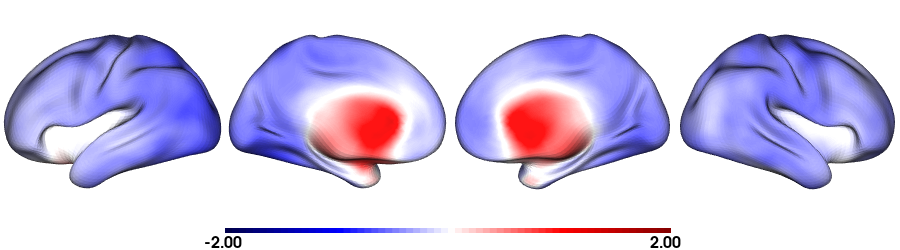

In [354]:
item= comps[3]
tsutil.printItemMetadata(item, idx=2)
metric = 'm_df_w_TLE_ic_ipsiTo-L_7T'
print(metric)
tsutil.itmToVisual(
                        item=item, 
                        df_name = df_name, 
                        metric = metric, 
                        ipsiTo = ipsiTo,
                        max_val = 2
                        )

	[('MICs', 'PNI')] - cortex: T1map, fsLR-5k, midthickness, 10mm (idx 2)
m_df_w_TLE_ic_ipsiTo-L_3T
[showBrains] WARNING: MICAPIPE environment variable not set. Using hard-coded path /data_/mica1/01_programs/micapipe-v0.2.0


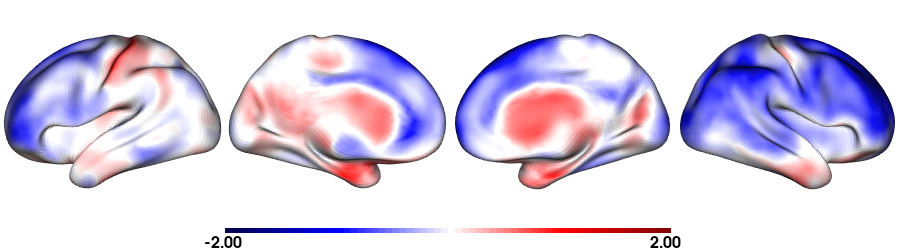

In [355]:
item= comps[3]
tsutil.printItemMetadata(item, idx=2)
metric = 'm_df_w_TLE_ic_ipsiTo-L_3T'
print(metric)
tsutil.itmToVisual(
                        item=item, 
                        df_name = df_name, 
                        metric = metric, 
                        ipsiTo = ipsiTo,
                        max_val = 2
                        )

test
[showBrains] WARNING: MICAPIPE environment variable not set. Using hard-coded path /data_/mica1/01_programs/micapipe-v0.2.0


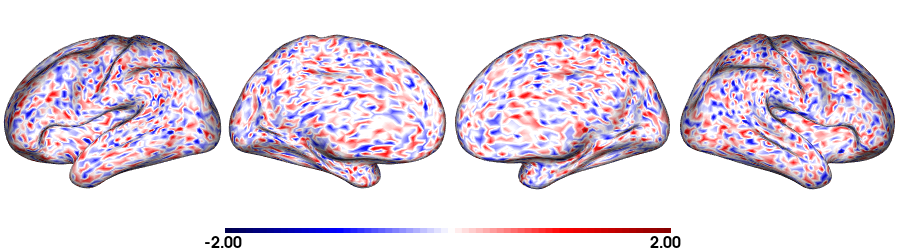

In [342]:
item= comps[3]
df_test = item['comps_df_d_ic']
# add to thise a row with numbers from -1 to 1 generated from a normal distribution
import numpy as np
df_test.loc['test'] = np.random.normal(0, 0.5, size=df_test.shape[1])
metric = 'test'
print(metric)

tsutil.itmToVisual(
                        item=item, 
                        df_name = df_name, 
                        metric = metric, 
                        ipsiTo = ipsiTo
                        )  

In [ ]:
importlib.reload(tsutil)

tsutil.visMean(
    comps,
    df_name = "comps_df_d_ic",
    df_metric="d_df_z_TLE_ic_ipsiTo-L_Δd",
    title="Mean z difference (7T-3T)",
    ipsiTo="L"
)

In [ ]:
# check unsmoothed map

pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/05_comps_11Sep2025-170446.pkl"
with open(pth, "rb") as f:
        comps = pickle.load(f)

# Apply parcellations and add to dict lists

In [42]:
importlib.reload(tsutil)

pth_win = "/host/verges/tank/data/daniel/3T7T/z/outputs/stats/dl_d_ic_13Jun2025-1633.pkl"
pth_comps = "/host/verges/tank/data/daniel/3T7T/z/outputs/results/comps_15Jun2025-1317.pkl"

win = pd.read_pickle(pth_win)
comps = pd.read_pickle(pth_comps)

print("============= Within Study ===============")
tsutil.print_dict(win, df_print=False)
print("=============== Comparison =============")
tsutil.print_dict(comps, df_print=False)

============= Within Study ===============

 Dict list length (2 items)

[0]
	Keys: ['study', 'label', 'df_demo_crtx', 'df_maps_crtx', 'df_demo_hipp', 'df_maps_hipp', 'n_ctrl_crtx', 'n_grp_crtx', 'df_z_crtx', 'n_ctrl_hipp', 'n_grp_hipp', 'df_z_hipp', 'df_z_crtx_ic', 'df_z_hipp_ic', 'df_d_crtx_ic', 'df_d_hipp_ic']
	study: MICs
	label: thickness
	df_demo_crtx: <DataFrame shape=(46, 9)>
	df_maps_crtx: <DataFrame shape=(31, 64986)>
	df_demo_hipp: <DataFrame shape=(20, 9)>
	df_maps_hipp: <DataFrame shape=(20, 14526)>
	n_ctrl_crtx: 11
	n_grp_crtx: 20
	df_z_crtx: <DataFrame shape=(31, 64984)>
	n_ctrl_hipp: 5
	n_grp_hipp: 15
	df_z_hipp: <DataFrame shape=(20, 14524)>
	df_z_crtx_ic: <DataFrame shape=(31, 64984)>
	df_z_hipp_ic: <DataFrame shape=(20, 14524)>
	df_d_crtx_ic: <DataFrame shape=(1, 64984)>
	df_d_hipp_ic: <DataFrame shape=(1, 14524)>

[1]
	Keys: ['study', 'label', 'df_demo_crtx', 'df_maps_crtx', 'df_demo_hipp', 'df_maps_hipp', 'n_ctrl_crtx', 'n_grp_crtx', 'df_z_crtx', 'n_ctrl_hipp', 'n_

In [ ]:
win = pd.read_pickle(pth_win)
comps = pd.read_pickle(pth_comps)

labelType = "Lobe_hemi"  # specify the label type for glasser parcellations
dictlists = [win, comps]
save_pths = ["dl_d_ic_glsr", "comps_glsr"]
out = []

for dl_it, sve_pth in zip(dictlists, save_pths):
    items_glsr = []
    #tsutil.print_dict(dl_it)
    for i, item in enumerate(dl_it):
        
        #tsutil.print_dict(item)
        for region in ['crtx']:
            ipsiTo = None

            # Only process Cohen's d DataFrames
            if 'df_d_' + region + '_ic' in item:
                df_name = f'df_d_{region}_ic'
                df = item[df_name]
                ipsiTo = "L"
            elif 'comps_' + region in item:
                df_name = f'comps_{region}'
                df = item[df_name]
                ipsiTo = "L"
            else:
                print(f"Skipping item {i} for region {region} (no d-score DataFrame).")
                continue
            #print(df.shape)
            
            if df is None:
                print(f"Skipping item {i} for region {region} as df is None.")
                continue

            df_glasser = tsutil.apply_glasser(df, ipsiTo=ipsiTo, labelType=labelType)
            print(df_glasser.shape)
            df_glasser_mean = df_glasser.groupby(df_glasser.columns, axis=1).mean()
            print(f"Glasser mean shape: {df_glasser_mean.shape}")

            df_out_name = f'{df_name}_glsr_{labelType}'
            item[df_out_name] = df_glasser_mean

        items_glsr.append(item)
    dl_it.clear()
    dl_it.extend(items_glsr)

    date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
    save_path = f"/host/verges/tank/data/daniel/3T7T/z/outputs/{sve_pth}_{date}.pkl"
    with open(save_path, "wb") as f:
        pickle.dump(dl_it, f)
    print(f"Saved dict list with glasser parcellations: {save_path}")


(1, 64984)
Glasser mean shape: (1, 11)
(1, 64984)
Glasser mean shape: (1, 11)
Saved dict list with glasser parcellations: /host/verges/tank/data/daniel/3T7T/z/outputs/dl_d_ic_glsr_15Jun2025-1340.pkl
(3, 64984)
Glasser mean shape: (3, 11)
Saved dict list with glasser parcellations: /host/verges/tank/data/daniel/3T7T/z/outputs/comps_glsr_15Jun2025-1341.pkl


In [ ]:
tsutil.print_dict(dl_it, df_print=False, idx=[0])


 Printing the following 1 indices: [0]

[0]
	Keys: ['study_3T', 'study_7T', 'label', 'ic', 'n_ctrl_crtx', 'n_ctrl_hipp', 'n_grp_crtx', 'n_grp_hipp', 'comps_crtx', 'comps_hipp', 'comps_crtx_glsr_Lobe_hemi']
	study_3T: MICs
	study_7T: PNI
	label: thickness
	ic: True
	n_ctrl_crtx: 11
	n_ctrl_hipp: 5
	n_grp_crtx: 20
	n_grp_hipp: 15
	comps_crtx: <DataFrame shape=(3, 64984)>
	comps_hipp: <DataFrame shape=(3, 14524)>
	comps_crtx_glsr_Lobe_hemi: <DataFrame shape=(3, 11)>


# Visualize

In [49]:
import pandas as pd
import importlib
import tTsTGrpUtils as tsutil

In [56]:
importlib.reload(tsutil)

pth_win = "/host/verges/tank/data/daniel/3T7T/z/outputs/dl_d_ic_glsr_15Jun2025-1340.pkl"
pth_btw = "/host/verges/tank/data/daniel/3T7T/z/outputs/comps_glsr_15Jun2025-1341.pkl"

win = pd.read_pickle(pth_win)
comps = pd.read_pickle(pth_btw)

print(f"---------WITHIN----------")
tsutil.print_dict(win, df_print=False)
print(f"\n\n---------COMPS----------")
tsutil.print_dict(comps, df_print=False)

---------WITHIN----------

 Dict list length (2 items)

[0]
	Keys: ['study', 'label', 'df_demo_crtx', 'df_maps_crtx', 'df_demo_hipp', 'df_maps_hipp', 'n_ctrl_crtx', 'n_grp_crtx', 'df_z_crtx', 'n_ctrl_hipp', 'n_grp_hipp', 'df_z_hipp', 'df_z_crtx_ic', 'df_z_hipp_ic', 'df_d_crtx_ic', 'df_d_hipp_ic', 'df_d_crtx_ic_glsr_Lobe_hemi']
	study: MICs
	label: thickness
	df_demo_crtx: <DataFrame shape=(46, 9)>
	df_maps_crtx: <DataFrame shape=(31, 64986)>
	df_demo_hipp: <DataFrame shape=(20, 9)>
	df_maps_hipp: <DataFrame shape=(20, 14526)>
	n_ctrl_crtx: 11
	n_grp_crtx: 20
	df_z_crtx: <DataFrame shape=(31, 64984)>
	n_ctrl_hipp: 5
	n_grp_hipp: 15
	df_z_hipp: <DataFrame shape=(20, 14524)>
	df_z_crtx_ic: <DataFrame shape=(31, 64984)>
	df_z_hipp_ic: <DataFrame shape=(20, 14524)>
	df_d_crtx_ic: <DataFrame shape=(1, 64984)>
	df_d_hipp_ic: <DataFrame shape=(1, 14524)>
	df_d_crtx_ic_glsr_Lobe_hemi: <DataFrame shape=(1, 11)>

[1]
	Keys: ['study', 'label', 'df_demo_crtx', 'df_maps_crtx', 'df_demo_hipp', 'df_ma

In [64]:
df = comps[0]['comps_crtx'].loc['dD']
df

0_ipsi         -0.408039
1_ipsi          0.561953
2_ipsi         -0.162673
3_ipsi         -0.302291
4_ipsi          0.265647
                  ...   
32487_contra    0.062607
32488_contra    0.058995
32489_contra    0.149764
32490_contra    0.144719
32491_contra    0.233453
Name: dD, Length: 64984, dtype: float64

Pairs for (thickness): [[0, 1]] [[0]]
	Saved PDF: /host/verges/tank/data/daniel/3T7T/z/outputs/fig_stats/figs/thickness_d_dD_by7T_15Jun2025-1432.pdf
Pairs for (thickness): [[0, 1]] [[0]]
	Saved PDF: /host/verges/tank/data/daniel/3T7T/z/outputs/fig_stats/figs/thickness_d_dD_by7T_15Jun2025-1433.pdf


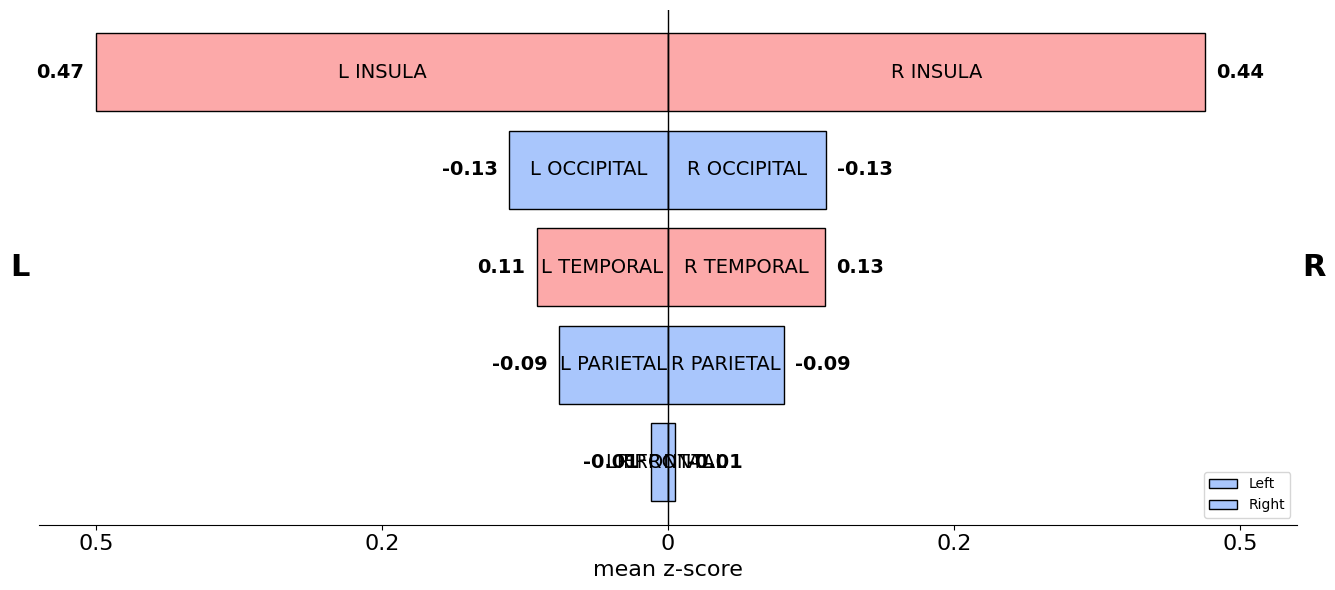

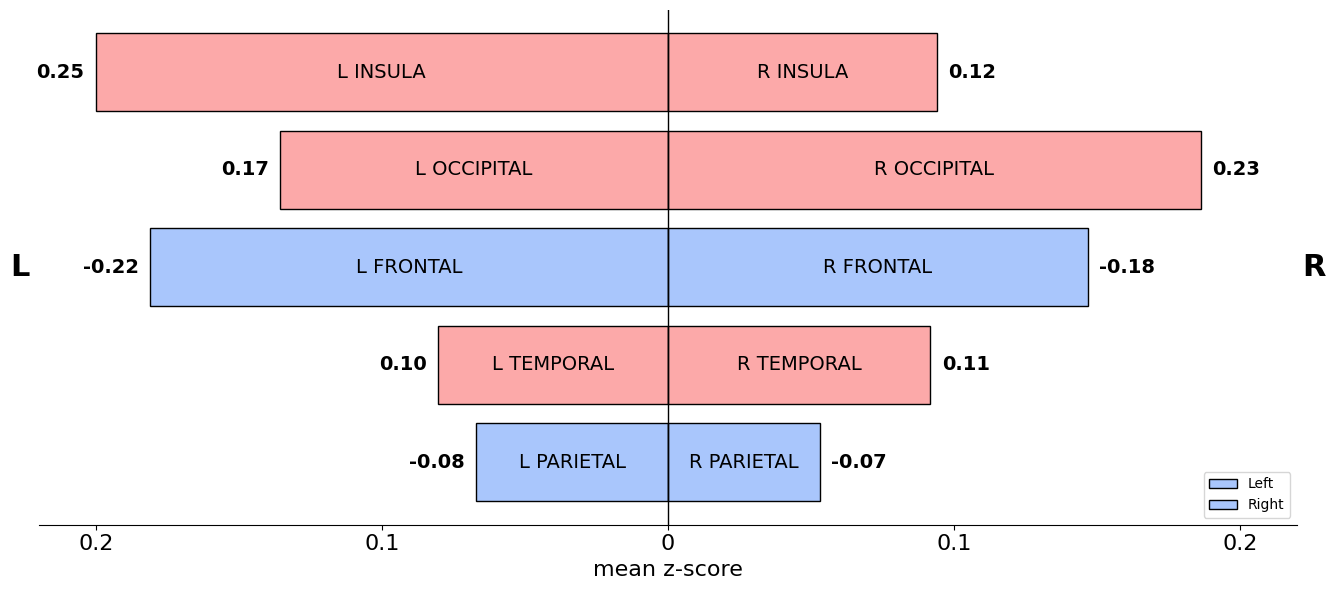

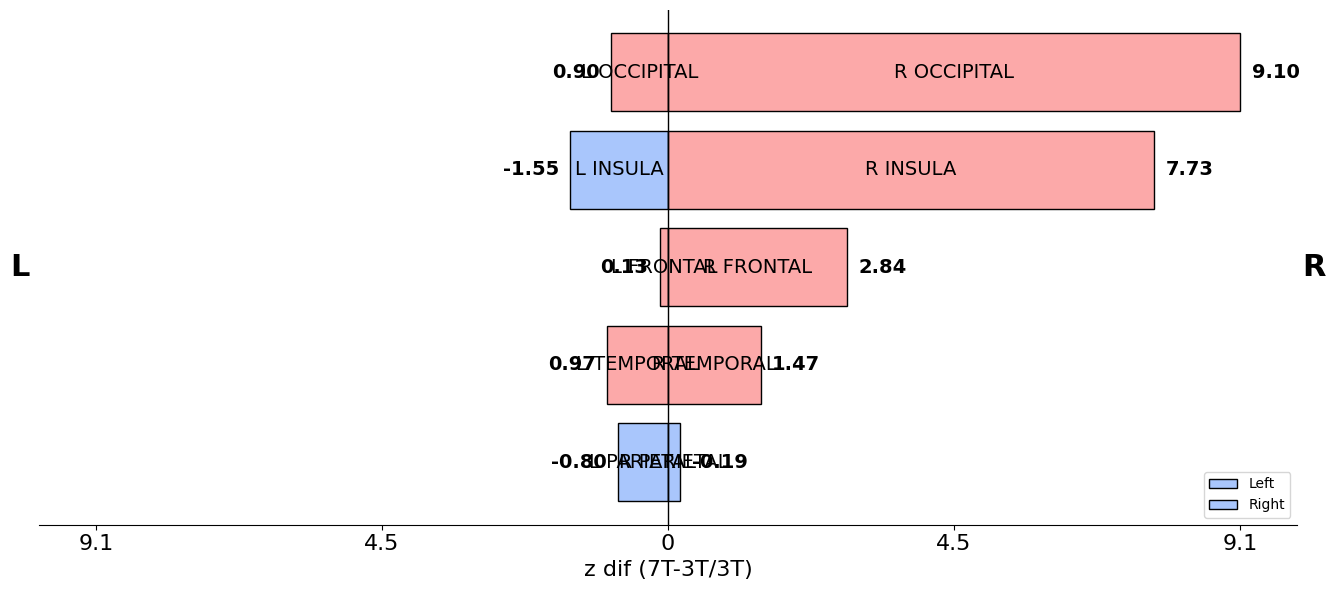

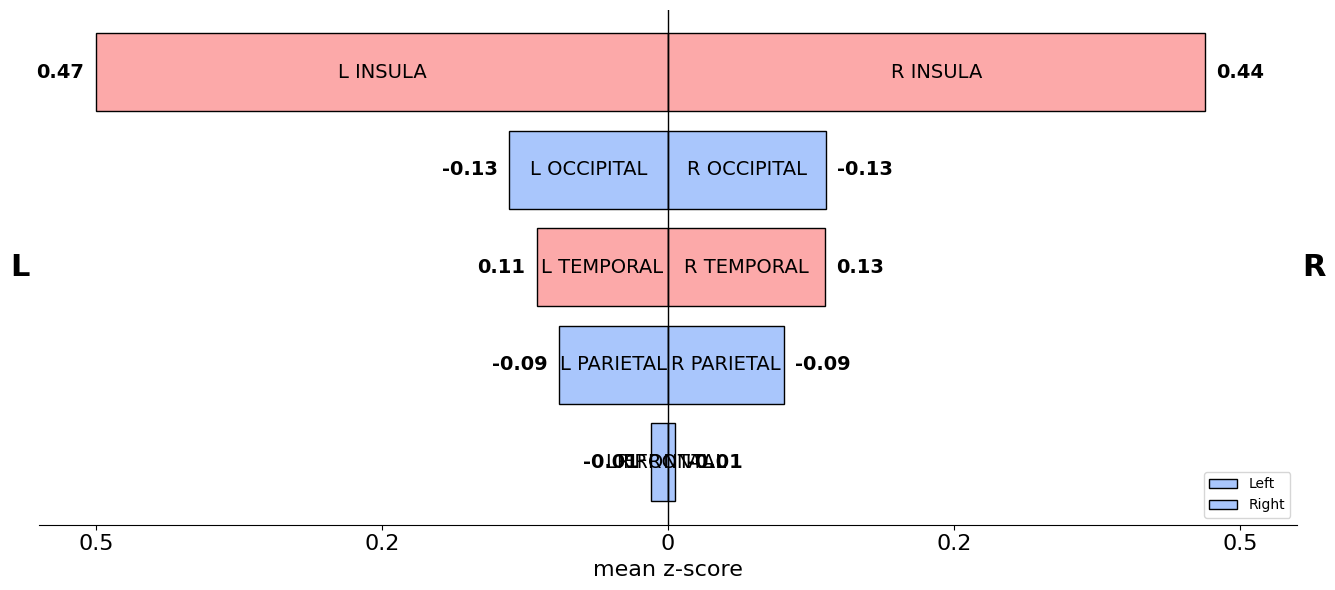

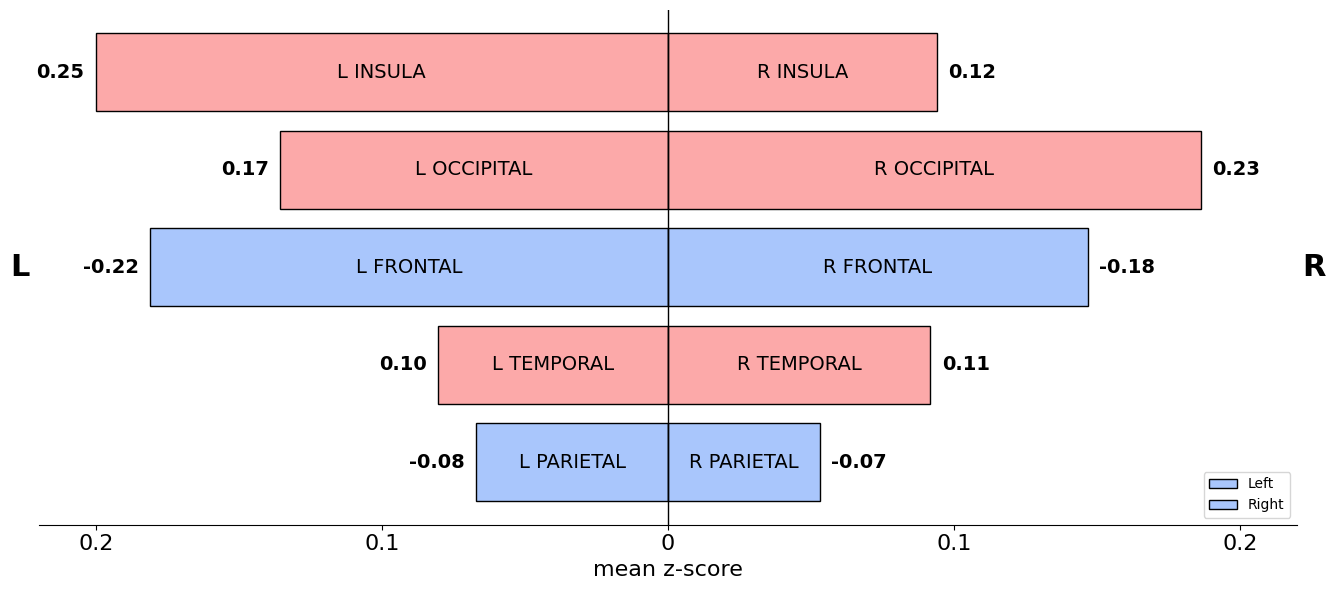

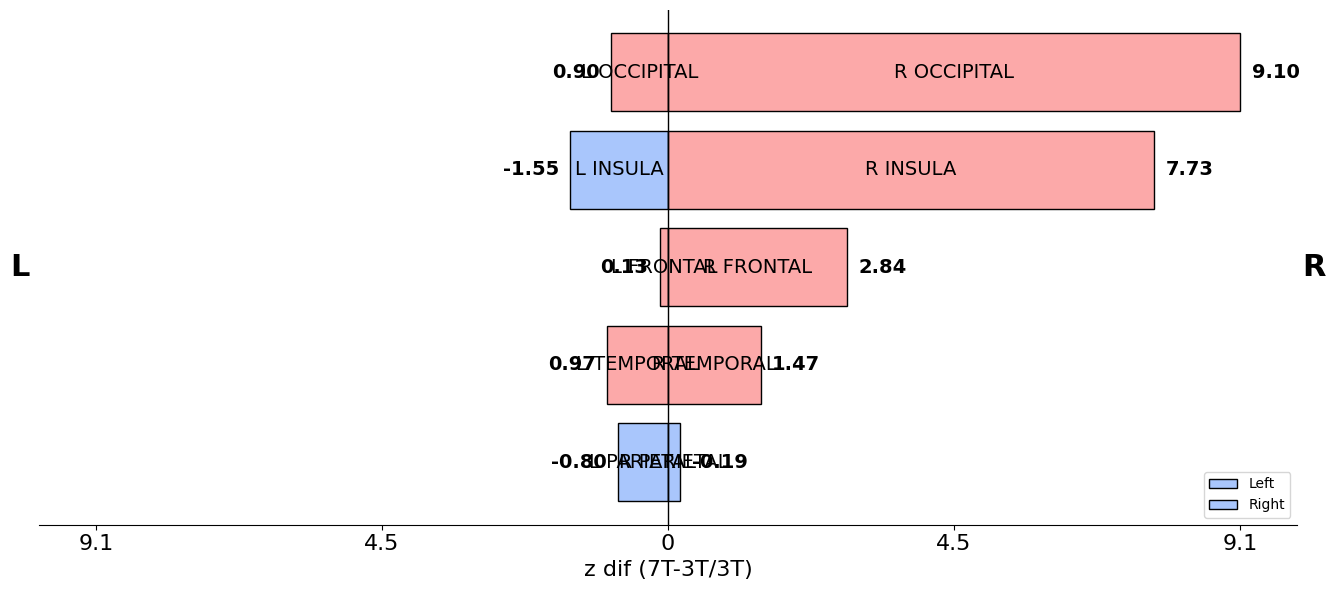

In [ ]:
# Generate one figure per group-lbl combination
importlib.reload(tsutil)
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import datetime

save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/fig_stats/figs"

winstudy = win
btwstudy = comps

win_metric = 'd'
btw_metric = 'dD_by7T'

skip_indices = []
for i, item in enumerate(winstudy):
    
    if item in skip_indices:
        continue

    winstudy_pair = tsutil.pairedItems(item, winstudy, mtch=['label'])
    btwstudy_pair = tsutil.pairedItems(item, btwstudy, mtch=['label'])
    print(f"Pairs for ({item['label']}): [{winstudy_pair}] [{btwstudy_pair}]")

    skip_indices.extend(winstudy_pair)

    figs = []
    # generate figures for within study comparisons
    for i in winstudy_pair:
        fig = tsutil.vis_item(win[i], metric = win_metric, ipsiTo = 'L', save_pth=None)
        figs.append(fig)

    for i in btwstudy_pair: # generate figures for between study comparisons
        fig = tsutil.vis_item(btwstudy[i], metric = btw_metric, ipsiTo = 'L',save_pth=None)
        figs.append(fig)
    
    # add each figure as seperate page to a pdf
    date = pd.Timestamp.now().strftime("%d%b%Y-%H%M")
    pdf_path = f"{save_pth}/{item['label']}_{win_metric}_{btw_metric}_{date}.pdf"
    with PdfPages(pdf_path) as pdf:
        for fig in figs:
            pdf.savefig(fig)
            plt.close(fig)
    print(f"\tSaved PDF: {pdf_path}")


In [ ]:
df = comps[0]['comps_crtx'].loc[['dD']]

In [ ]:
# identify paired items in zmean and comps
# send these three items to vis_win_comp

def vis_win_comp(tT_item, sT_item, comp_item, save_name=None, save_path = None, ipsiTo='L'):
    # in three rows, plot:
    # [0] 3T grp to ctrl : annotation 3T \n mean z ({n} 'grp' to {n} 'ctrl')
    # [1] 7T grp to ctrl : annotation 7T \n mean z ({n} 'grp' to {n} 'ctrl')
    # [2] 3T-7T grp to ctrl : z difference (7T - 3T / 3T)
    # annotate the figures with L/R (if grp is TLE_L or TLE_R) or ipsi/contra (if grp is TLE_IC)


# OUTDATED below

In [ ]:
map_pths_clean = []
final_ses = []
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/pt"

# Step 1: Clean sessions for each item in map_pths using clean_ses
map_pths_clean = []
for item in map_pths:
    df = item['map_pths']
        # Clean sessions
    df_clean = clean_ses(df, ID_col="ID", method="newest", silent=True)
    if df_clean is not None and not df_clean.empty:
        new_item = item.copy()
        new_item['map_pths'] = df_clean
        map_pths_clean.append(new_item)

# save dictionary list to a pickle file
save_cleanMaps = "/host/verges/tank/data/daniel/3T7T/z/maps/paths"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f"{save_cleanMaps}/map_pths_{date}.pkl", "wb") as f:
    pickle.dump(map_pths_clean, f)
print(f"Saved map_pths to {save_cleanMaps}/map_pths_{date}.pkl")


# Step 2: Return sessions used per ID
save_finalSES = "/host/verges/tank/data/daniel/3T7T/z/outputs/pt"
finalSES = get_finalSES(map_pths_clean, demo=demographics, save_pth=save_finalSES, long=True, silent=True)

In [ ]:
print_dict(map_pths_clean)


map_pths_clean (414 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>

Item 2:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k

# Add ipsi/contra groups

In [ ]:
# Create ipsi-contra dict entries
grps = ["TLE_L", "TLE_R"]

ic_entries = []

print(len(map_pths_clean))

for study in studies:
    print(f"\n[flip_TLE] Processing study {study['name']} for ipsi-contra entries")
    # find all entries for the groups of interest
    index_list = [
        i for i, item in enumerate(map_pths_clean)
        if item['study'] == study['name'] and item['grp'] in grps
    ]
    print(index_list)
    print(f"\n{len(index_list)} entries for groups {grps}")

    paired = set()  # to keep track of paired indices
    loop_count = 0

    for i in index_list:
        if i in paired:
            continue
        else:
            paired.add(i)

        # Only pair if surface, label, and feature match
        item_i = map_pths_clean[i]
        grp_i = item_i['grp']
        df_i = item_i['map_pths']
        surface_i = item_i['surface']
        label_i = item_i['label']
        feature_i = item_i['feature']
        # add grp col to DF
        df_i['grp'] = grp_i

        if grp_i == 'TLE_L':
            grp_other = 'TLE_R'
        elif grp_i == 'TLE_R':
            grp_other = 'TLE_L'
        else:
            print(f"Skipping item {i} with group {grp_i} (not TLE_L or TLE_R)")
            continue

        # Find paired index with matching surface, label, feature, and opposite group
        other_i = None
        for j in index_list:
            if j == i or j in paired:
                continue
            item_j = map_pths_clean[j]
            if (
                item_j['grp'] == grp_other and
                item_j['surface'] == surface_i and
                item_j['label'] == label_i and
                item_j['feature'] == feature_i
            ):
                other_i = j
                break

        if other_i is not None:
            item_other = map_pths_clean[other_i]
            df_other = item_other['map_pths']
            if df_other is not None: df_other['grp'] = grp_other
            paired.add(other_i)
        else:
            item_other = None
            grp_other = None
            df_other = None

        print(f"\t{loop_count} {i} & {other_i} | {item_i['label']}, {item_i['feature']}, {item_i['surface']} | {grp_i} & {grp_other}")

        out = item_i.copy()  # copy to avoid modifying original

        # rename path cols
        # Find the correct map column names for L/R
        hemi_L = [col for col in df_i.columns if col.endswith('_L')]
        hemi_R = [col for col in df_i.columns if col.endswith('_R')]

        col_L = hemi_L[0]
        col_R = hemi_R[0]

        if grp_i == 'TLE_L':
            df_i = df_i.rename(columns={col_L: 'pth_ipsi', col_R: 'pth_contra'})
            if df_other is not None:
                df_other = df_other.rename(columns={col_R: 'pth_ipsi', col_L: 'pth_contra'})
        else:  # grp_i == 'TLE_R'
            df_i = df_i.rename(columns={col_R: 'pth_ipsi', col_L: 'pth_contra'})
            if df_other is not None:
                df_other = df_other.rename(columns={col_L: 'pth_ipsi', col_R: 'pth_contra'})

        # combine modified dfs
        if df_other is not None:
            dfs = pd.concat([df_i, df_other], ignore_index=True)
            out['grp_labels'] = [grp_i, grp_other]
        else:
            dfs = df_i
            out['grp_labels'] = [grp_i]

        out['map_pths'] = dfs  # add the combined dataframe to the output item
        out['grp'] = 'TLE_ic'  # ic for ipsi-contra

        # add to the list of outputs
        ic_entries.append(out)

        loop_count += 1

map_pths_clean_ic = map_pths_clean + ic_entries  # combine original entries with ipsi-contra entries

# Save the updated map_pths_clean to a pickle file
save_cleanMaps = "/host/verges/tank/data/daniel/3T7T/z/maps/paths"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f"{save_cleanMaps}/map_pths_clean_{date}.pkl", "wb") as f:
    pickle.dump(map_pths_clean_ic, f)
print(f"Saved map_pths_clean to {save_cleanMaps}/map_pths_clean_{date}.pkl")

NameError: name 'map_pths_clean' is not defined

In [ ]:
# Find entries with TLE_L, pial, FA, MICs
selected = [item for item in map_pths_clean_ic if item['grp'] == 'TLE_R' and item['label'] == 'white' and item['feature'] == 'FA' and item['study'] == 'PNI']
print_dict(selected)


map_pths_clean (0 items):


In [ ]:
# Print the structure of the selected items in map_pths_clean using index_list
print_dict(map_pths_clean_ic[270:290], df_print=False)


map_pths_clean (20 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: PNI
 grp: TLE_L
 grp_labels: ['TLE_L', 'mTLE_L']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(4, 6)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: PNI
 grp: TLE_L
 grp_labels: ['TLE_L', 'mTLE_L']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(4, 6)>

Item 2:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: PNI
 grp: TLE_L
 grp_labels: ['TLE_L', 'mTLE_L']
 surface: fsLR-5k
 label: white
 feature: T1map
 hippocampal: False
  map_pths: <DataFrame shape=(5, 6)>

Item 3:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: PNI
 grp: TLE_L
 grp_labels: ['TLE_L', 'mTLE_L']
 surface: 

In [ ]:
# print structure of map_pths_clean
print_dict(map_pths_clean_ic)


map_pths_clean (468 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>

Item 2:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k

In [ ]:
# print specific study-group combinations
print_grpDF(dict=map_pths_clean_ic, grp='ctrl', study='PNI', df="pth")

PNI-ctrl (['CTRL'])
         ID SES        Date  \
2    PNC003  02  13.06.2022   
6    PNC006  02  05.11.2022   
10   PNC011  02  11.11.2022   
14   PNC018  02  05.05.2023   
28   PNC019  a1  27.02.2025   
105  PNC024  a1  09.10.2024   
109  PNC025  a1  11.09.2024   
113  PNC026  a1  16.10.2024   
155  PNC037  a1  15.05.2025   
156  PNC038  a1  14.05.2025   

                                map_FA_fsLR-5k_white_L  \
2    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
6    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
10   /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
14   /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
28   /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
105  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
109  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
113  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
155  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
156  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   


In [ ]:
# Find path for specific participant
study = "PNI"
sub = "PNC018"
ses = "01"

grp_idx = "ctrl"

entry = next((item for item in map_pths if item['study'] == study and item['grp'] == grp_idx), None)

if entry is not None:
    df = entry['map_pths']
    row = df[(df[col_ID] == sub) & (df['SES'] == ses)]
    if not row.empty:
        print(row['pth_L'].values[0])
    else:
        print(f"No entry found for subject {sub} and session {ses}")
else:
    print(f"No entry found for study {study} and group {grp_idx}")

/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-PNC018/ses-01/maps/sub-PNC018_ses-01_hemi-L_surf-fsLR-5k_label-white_FA.func.gii


# Extract map values

In [ ]:
import pickle

with open("/host/verges/tank/data/daniel/3T7T/z/maps/paths/map_pths_clean_03Jun2025-2138.pkl", "rb") as f:
    map_pths_clean_ic = pickle.load(f)


In [ ]:
print_dict([map_pths_clean_ic[25]], df_print=True)# print specific study-group combinations (prints first feature-label combination)


 dict: (1 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: 0p5mm
 label: midthickness
 feature: ADC
 hippocampal: True
  map_pths: <DataFrame shape=(19, 6)>
  map_pths:         ID SES        Date                  map_ADC_0p5mm_midthickness_hipp_L  \
176  PX119  01  30.08.2023  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
177  PX071  04  26.09.2023  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
181  PX137  01  06.03.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
182  PX148  01  06.05.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
184  PX153  01  28.05.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
185  PX158  01  11.06.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
189  PX168  01  20.08.2024  /host/verges/tank

In [ ]:
# print specific study-group combinations (prints first feature-label combination)
print_grpDF(dict=map_pths_clean_ic, grp='allPX', study='MICs', hipp = True, df="maps")

MICs-allPX (['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R'])
        ID SES        Date  \
176  PX119  01  30.08.2023   
177  PX071  04  26.09.2023   
181  PX137  01  06.03.2024   
182  PX148  01  06.05.2024   
184  PX153  01  28.05.2024   
185  PX158  01  11.06.2024   
189  PX168  01  20.08.2024   
190  PX173  01  28.08.2024   
191  PX174  01  04.09.2024   
192  PX176  01  05.09.2024   
193  PX183  01  16.10.2024   
195  PX189  01  12.11.2024   
196  PX190  01  12.11.2024   
197  PX194  01  26.11.2024   
198  PX198  01  03.12.2024   
199  PX199  01  03.12.2024   
200  PX200  01  03.12.2024   
201  PX204  01  09.01.2025   
204  PX215  01  20.03.2025   

                                                                                             map_FA_0p5mm_outer_hipp_L  \
176  /host/verges/tank/data/daniel/3T7T/z/maps/sub-PX119_ses-01/sub-PX119_ses-01_map_FA_0p5mm_outer_L_smth-10.func.gii   
177  /host/verges/tank/data/daniel/3T

In [ ]:
# Each row is a vertex, each column is a subject-session
## note for ipsi/contra groups, the following map values are stored under keys : maps_ipsi, maps_contra
maps = []
print_dict(maps)

for item in map_pths_clean_ic:

    #print(f"{item['study']} - {item['grp']} - {item['feature']} - {item['label']} - {item['surface']}")

    df = item['map_pths']

    # Find the ID column (use existing variable if available)
    if 'ID_col' in globals():
        id_col = col_ID
    else:
        id_col = [col for col in df.columns if 'ID' in col.upper()][0]

    # identify pth columns
    pth_cols = [col for col in df.columns if col.startswith('pth_') or col.startswith('map_')]
    print(f"\t{pth_cols}")

    new_item = item.copy()  # Only copy once per item

    for pth in pth_cols:
        df_map = pd.DataFrame()
        for i, row in df.iterrows():
            sub = row[id_col]
            ses = row['SES']

            # extract map values
            val = row[pth]
            # Check for missing or invalid path
            if pd.isnull(val) or str(val).startswith("ERROR") or str(val).lower() == "nan":
                print(f"{item['study']} - {item['grp']} - {item['feature']} - {item['label']} - {item['surface']}")
                print(f"\t[main] WARNING: No map path for {sub} {ses} ({pth}): {val}")
                continue
            try:
                gii = nib.load(val)
                map_data = gii.darrays[0].data
            except Exception as e:
                print(f"\t[main] ERROR loading {val}: {e}")
                continue

            col_name = f"{sub}-{ses}"
            df_map[col_name] = map_data

        # add the dataframe to dict item if not empty
        key_name = pth.replace('pth_', '').replace('surf_', '')
        if not df_map.empty:
            new_item[f'{key_name}'] = df_map

    # add this item to the maps list
    maps.append(new_item)



 dict: (0 items):
MICs - allPX - FA - white - fsLR-5k
	['map_FA_fsLR-5k_white_L', 'map_FA_fsLR-5k_white_R']
MICs - allPX - ADC - white - fsLR-5k
	['map_ADC_fsLR-5k_white_L', 'map_ADC_fsLR-5k_white_R']
MICs - allPX - T1map - white - fsLR-5k
	['map_T1map_fsLR-5k_white_L', 'map_T1map_fsLR-5k_white_R']
MICs - allPX - FA - midthickness - fsLR-5k
	['map_FA_fsLR-5k_midthickness_L', 'map_FA_fsLR-5k_midthickness_R']
MICs - allPX - ADC - midthickness - fsLR-5k
	['map_ADC_fsLR-5k_midthickness_L', 'map_ADC_fsLR-5k_midthickness_R']
MICs - allPX - T1map - midthickness - fsLR-5k
	['map_T1map_fsLR-5k_midthickness_L', 'map_T1map_fsLR-5k_midthickness_R']
MICs - allPX - FA - pial - fsLR-5k
	['map_FA_fsLR-5k_pial_L', 'map_FA_fsLR-5k_pial_R']
MICs - allPX - ADC - pial - fsLR-5k
	['map_ADC_fsLR-5k_pial_L', 'map_ADC_fsLR-5k_pial_R']
MICs - allPX - T1map - pial - fsLR-5k
	['map_T1map_fsLR-5k_pial_L', 'map_T1map_fsLR-5k_pial_R']
MICs - allPX - FA - white - fsLR-32k
	['map_FA_fsLR-32k_white_L', 'map_FA_fsLR-32

In [ ]:
# print the structure of the maps
print_dict(maps)



 dict: (468 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>
  map_map_FA_fsLR-5k_white_L: <DataFrame shape=(4842, 19)>
  map_map_FA_fsLR-5k_white_R: <DataFrame shape=(4842, 19)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>
  map_map_ADC_fsLR-5k_white_L: <Da

In [ ]:
# print the unique values for the key 'grp' 
unique_grps = set(item['grp'] for item in maps)
print(f"Unique groups in maps: {unique_grps}")

Unique groups in maps: {'ctrl', 'TLE_ic', 'TLE_R', 'TLE', 'allPX', 'FCD', 'TLE_L', 'UKN', 'MFCL'}


In [ ]:
# save dictionary item
save_pth = "/host/verges/tank/data/daniel/3T7T/z/maps/map_dfs/"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f'{save_pth}/map_values_{date}.pkl', 'wb') as f:    pickle.dump(maps, f)

In [ ]:
# print specific study-group combinations (prints first feature-label combination)
print_grpDF(dict=maps, grp='ctrl', study='PNI', df="maps")

# Statistics

In [ ]:
def t_test(df1, df2, fdr=True, equal_var=False):
    """
    Perform a vertex wise t-test between two DataFrames.
    inputs:
        df1: pd.DataFrame with vertex data for group 1. Vertices should be rows, subjects as columns.
        df2: pd.DataFrame with vertex data for group 2.
        fdr: whether to apply FDR correction to the p-values (default is True)
        equal_var: whether to assume equal variance between the two groups (default is False, i.e., Welch's t-test)

    outputs:
        df with shape n_vertices x 2 . Cols:
            't': t-statistic
            'p': p-value
            'p_fdr' < if fdr = True >: FDR-corrected p-value


    Note:
     - Assumes:
      - Values at each vertex are normally distributed
      - Participants are independent
      - Unequal variance
    """
    import pandas as pd
    from scipy import stats
    import numpy as np

    if df1.shape[0] != df2.shape[0]:
        raise ValueError("[t_test] DataFrames must have the same number of vertices (rows).")
    
    if df1.shape[1] < 2 or df2.shape[1] < 2:
        raise ValueError("[t_test] Each DataFrame must have at least two subjects for t-test. {}".format((df1.shape, df2.shape)))
    
    # Initialize output DataFrame
    out = pd.DataFrame(index=df1.index)
    out['t'] = np.nan
    out['p'] = np.nan
    out['p_fdr'] = np.nan

    # Perform t-test for each vertex
    for i in range(df1.shape[0]):
        t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)
        out.at[i, 't'] = t_stat
        out.at[i, 'p'] = p_val

    # FDR correction if requested
    if fdr:
        from statsmodels.stats.multitest import multipletests
        out['p_fdr'] = multipletests(out['p'], method='fdr_bh')[1]  # FDR correction

    return out


def d(df1, df2):
    """
    Calculate Cohen's d for each vertex between two DataFrames.

    inputs:
        df1: pd.DataFrame with vertex data for group 1. Vertices should be rows, subjects as columns.
        df2: pd.DataFrame with vertex data for group 2.

    outputs:
        pd.DataFrame with shape n_vertices x 1. Cols:
            'd': Cohen's d value for each vertex
    """
    import pandas as pd
    import numpy as np

    if df1.shape[0] != df2.shape[0]:
        raise ValueError("[d] DataFrames must have the same number of vertices (rows).")
    
    if df1.shape[1] < 2 or df2.shape[1] < 2:
        raise ValueError("[d] Each DataFrame must have at least two subjects for d calculation. {}".format((df1.shape, df2.shape)))

    # Initialize output DataFrame
    out = pd.DataFrame(index=df1.index)
    out['d'] = np.nan
    
    # Calculate Cohen's d for each vertex
    for i in range(df1.shape[0]):
        mean1 = df1.iloc[i, :].mean()
        mean2 = df2.iloc[i, :].mean()
        std1 = df1.iloc[i, :].std(ddof=1)  # Sample standard deviation
        std2 = df2.iloc[i, :].std(ddof=1)
        n1 = df1.shape[1]
        n2 = df2.shape[1]

        pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
        # Avoid division by zero: if pooled_std is zero, set d to np.nan
        if pooled_std == 0 or np.isnan(pooled_std):
            out.at[i, 'd'] = np.nan
        else:
            out.at[i, 'd'] = (mean1 - mean2) / pooled_std

    return out

def get_stats(maps, ipsiTo = "L", ctrl_lbl='ctrl', grps=['each'], fdr=True):
    """
    Perform statistical tests between groups in the maps list.
    
    inputs:
        maps: list of dictionary items with keys 'study', 'grp', 'label', 'feature', 'map_pths'
        ipsiTo: hemisphere to compare ipsilateral maps to (default is "L").
        ctrl_lbl: label for the control group (default is 'ctrl').
        grps: list of groups to run for. If "each", compare all groups to ctrl (except for ctrl grp to itself).
            Default is ["each"].

    outputs:
        stats: list of dictionary items with keys:
            'study': study name
            'grp': group name
            'label': surface label
            'feature': feature name
            't': t-statistic DataFrame
            'p': p-value DataFrame
            'p_fdr': FDR-corrected p-value DataFrame (if fdr=True)
            'd': Cohen's d DataFrame
    """

    import pandas as pd

    out = []

    if grps == ['each']:
        grps = list({item['grp'] for item in maps if item['grp'] != ctrl_lbl})

    for grp in grps:
        # find the index of these groups in the maps list
        grp_indices = [i for i, item in enumerate(maps) if item['grp'] == grp]
        
        for idx in grp_indices:
            comp = maps[idx]
            
            group = comp['grp']
            study = comp['study']
            surface = comp['surface']
            label = comp['label']
            feature = comp['feature']
            hippocampal = comp.get('hippocampal', False)
            print(f"\n[get_stats] [idx: {idx}] {study} {group} ({label}, {feature}, {surface}, {'hipp' if hippocampal else 'cort'})")
            
            # find the control group index
            idx_ctrl = ctrl_index(maps, idx)            
            ctrl = maps[idx_ctrl]
            
            if 'hippocampal' not in comp:
                comp['hippocampal'] = hippocampal
            
            comp_keys = [key for key in comp.keys() if key.startswith('map_') and not key.endswith('pths')]
            ctrl_keys = [key for key in ctrl.keys() if key.startswith('map_') and not key.endswith('pths')]
            print(f"\tMap keys: {comp_keys}")
            print(f"\tControl keys: {ctrl_keys}")

            for key in comp_keys: # compare L and/or R hemisphere maps
                
                if 'ipsi' in key:
                    ctrl_col = f"map_map_{feature}_{surface}_{label}_{ipsiTo}"
                    comp['ipsiTo'] = ipsiTo
                elif 'contra' in key and ipsiTo == "L":
                    ctrl_col = f"map_map_{feature}_{surface}_{label}_R"
                    comp['ipsiTo'] = ipsiTo
                elif 'contra' in key and ipsiTo == "R":
                    ctrl_col = f"map_map_{feature}_{surface}_{label}_L"
                    comp['ipsiTo'] = ipsiTo
                elif 'ipsi' in key or 'contra' in key:
                    assert key in ctrl_keys, f"Provided comparison key {key} not in control keys ({ctrl_keys}). Check that ipsiTo is set either to `L` or `R`."
                    continue  # skip if ipsi/contra is in key but not in control keys
                else:
                    ctrl_col = key

                # ensure that ctrl_col is in ctrl_keys
                if ctrl_col not in ctrl_keys:
                    print(f"\tWARNING. Control column {ctrl_col} not found in control keys. Skipping. {ctrl_keys}.")
                    break
                
                df_comp = comp[key]
                df_ctrl = ctrl[ctrl_col]
                print(f"\t{key}, ctrl: {ctrl_col} | comp: {df_comp.shape}, ctrl: {df_ctrl.shape}")

                n_ctrl = df_ctrl.shape[1]
                n_comp = df_comp.shape[1]

                # if n_ctrl and n_comp are not already in comp, add them. If they are, then assert that they are the same
                if 'n_ctrl' in comp and 'n_comp' in comp:
                    assert comp['n_ctrl'] == n_ctrl, f"Number of control participants changed from {comp['n_ctrl']} to {n_ctrl} for {key_stats}."
                    assert comp['n_comp'] == n_comp, f"Number of comparison participants changed from {comp['n_comp']} to {n_comp} for {key_stats}."
                else:
                    comp['n_ctrl'] = n_ctrl
                    comp['n_comp'] = n_comp

                if n_ctrl < 2 or n_comp < 2:
                    print(f"[main] Skipping case. too few participants for t-test ({n_comp} comp, {n_ctrl} ctrl).")
                    break
                
                out_t_p = t_test(df_comp, df_ctrl, fdr=True, equal_var=False)
                out_d = d(df_comp, df_ctrl)

                # combine results into a single DataFrame
                out_df = pd.DataFrame(index=df_comp.index)
                out_df['t'] = out_t_p['t']
                out_df['p'] = out_t_p['p']
                out_df['p_fdr'] = out_t_p['p_fdr']
                out_df['d'] = out_d['d']
            
                # new key:
                key_stats = key.replace('map_', 'stats_')

                # add out_df to the comp item
                comp[key_stats] = out_df
            
                #print(out_df.shape)

            # add to the list of outputs
            out.append(comp)

    return out


In [ ]:
def get_idx_compl(ldict, idx, silent=True):
    """
    Given a list of dict items and an index, find comparison that is for the same group, label, feature, but different study. 
    Get the comparison dictionary item at a specific index from a list of comparison items.
    
    inputs:
        ldict: list of comparison dictionary items
        idx: index of the item to retrieve

    outputs:
        idx_compl: str, index of the comparison dictionary item that is complementary to input index

    """
    if idx < 0 or idx >= len(ldict):
        print(f"WARNING: Index {idx} out of bounds for list of length {len(ldict)}")
        return None

    study = ldict[idx]['study']

    if study == "PNI":
        other_study = "MICs"
    elif study == "MICs":
        other_study = "PNI"
    else:
        print(f"WARNING: [get_idx_compl] Study code {study} not recognized. Only 'PNI' and 'MICs' are currently supported.")
        return None

    # Find all other list items that differ only in study (ignore values for 'stats')
    idx_compl = [i for i, item in enumerate(ldict) if item['study'] == other_study and 
                        item['label'] == ldict[idx]['label'] and 
                        item['feature'] == ldict[idx]['feature'] and 
                        item['grp'] == ldict[idx]['grp'] and
                        item['surface'] == ldict[idx]['surface'] and
                        item.get('hippocampal', False) == ldict[idx].get('hippocampal', False)
                ]

    idx_compl = idx_compl[0] if idx_compl else None  # Get the first matching index, if any

    if idx_compl is None:
        print(f"WARNING: [get_idx_compl] No complementary item found for index {idx} in study {study}.")

    if not silent: print(f"[get_idx_compl] Complementary index {idx_compl}")
    return idx_compl

def stat_dif(df1, df2, stat_col='d'):
    """
    Calculate the difference between columns in two analogous DataFrames.
    df1 - df2

    inputs:
        df1: pd.DataFrame with statistics for comparisons between grp and ctrl for study 1. Vertices should be rows, subjects as columns.
        df2: pd.DataFrame with vertex data for comparisons between grp and ctrl for study 2.
        stat_col: column name for to compare (default is 'd'). (must be present in both DataFrames)
            examples: 'd' for cohen's d, 't' for t-statistic

    outputs:
        pd.DataFrame with shape n_vertices x 1. Cols:
            'd_dif': Difference in Cohen's d value for each vertex
    """
    import pandas as pd
    import numpy as np

    if df1.shape[0] != df2.shape[0]:
        raise ValueError("[d_dif] DataFrames must have the same number of vertices (rows).")
    
    # Initialize output DataFrame
    out = pd.DataFrame()
    out[f'{stat_col}_dif'] = np.nan

    # take difference between d values
    for i in range(df1.shape[0]):
        d1 = df1.at[i, stat_col]
        d2 = df2.at[i, stat_col]
        
        if pd.isna(d1) or pd.isna(d2):
            out.at[i, f'{stat_col}_dif'] = np.nan
        else:
            out.at[i, f'{stat_col}_dif'] = d1 - d2  # Difference in Cohen's d

    return out

def stat_div(df1, df2, stat_col='d'):
    """
    Calculate the ratio between columns in two analogous DataFrames.
    df1 / df2

    inputs:
        df1: pd.DataFrame with statistics for comparisons between grp and ctrl for study 1. Vertices should be rows, subjects as columns.
        df2: pd.DataFrame with vertex data for comparisons between grp and ctrl for study 2.
        stat_col: column name for to compare (default is 'd'). (must be present in both DataFrames)
            examples: 'd' for cohen's d, 't' for t-statistic

    outputs:
        pd.DataFrame with shape n_vertices x 1. Cols:
            'd_div': Ratio in Cohen's d value for each vertex
    """
    import pandas as pd
    import numpy as np

    if df1.shape[0] != df2.shape[0]:
        raise ValueError("[d_div] DataFrames must have the same number of vertices (rows).")
    
    # Initialize output DataFrame
    out = pd.DataFrame()
    out[f'{stat_col}_div'] = np.nan

    # take ratio between d values
    for i in range(df1.shape[0]):
        d1 = df1.at[i, stat_col]
        d2 = df2.at[i, stat_col]
        
        if pd.isna(d1) or pd.isna(d2) or d2 == 0:
            out.at[i, f'{stat_col}_div'] = np.nan
        else:
            out.at[i, f'{stat_col}_div'] = d1 - d2 / d2  # Ratio in Cohen's d

    return out


In [ ]:
# import maps from saved object

import pickle

path = "/host/verges/tank/data/daniel/3T7T/z/maps/map_dfs/map_values_06Jun2025-1808.pkl"

with open(path, "rb") as f:
    maps = pickle.load(f)


In [ ]:
print_dict([maps[40]], df_print=True)


 dict: (1 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_ADC_fsLR-32k_midthickness_L', 'map_map_ADC_fsLR-32k_midthickness_R']
 study: MICs
 grp: TLE
 grp_labels: ['TLE_L', 'TLE_R', 'TLE_U', 'mTLE_R', 'mTLE_L']
 surface: fsLR-32k
 label: midthickness
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(9, 6)>
  map_pths:         ID SES        Date                    map_ADC_fsLR-32k_midthickness_L  \
177  PX071  04  26.09.2023  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
182  PX148  01  06.05.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
189  PX168  01  20.08.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
190  PX173  01  28.08.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
191  PX174  01  04.09.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
195  PX189  01  12.11.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
196  PX190  01  12.11.2

In [ ]:
# check map dfs. If L and R are not the same number, then keep only overlapping ID-ses. Save as maps_clean
# keys of interest: map_map_{feature}_{surface}_{label}_{hemi}

def clean_map_dfs(maps):
    """
    Clean map DataFrames if there are different number of cases in both map value dataframes. In this case, keep only overlapping subjects and sessions.
    
    inputs:
        maps: list of dictionary items with keys 'study', 'grp', 'label', 'feature', 'map_pths'
    
    outputs:
        maps_clean: list of dictionary items with cleaned map DataFrames
    """
    import pandas as pd

    maps_clean = []

    for item in maps:
        new_item = item.copy()  # Copy the item to avoid modifying the original
        map_keys = [key for key in item.keys() if key.startswith('map_') and not key.endswith('pths')]
        
        #print(f"[clean_map_dfs] Maps dataframe keys: {map_keys}")
        if len(map_keys) != 2:
            
            print(f"[clean_map_dfs] There are not exactly 2 map value keys. skipping.")
            continue

        df1 = new_item[map_keys[0]]
        df2 = new_item[map_keys[1]]
        if df1.shape[1] != df2.shape[1]:
            index = maps.index(item)
            print(f"[clean_map_dfs] [idx: {index}] Different number of cases in {map_keys[0]} ({df1.shape[1]}) and {map_keys[1]} ({df2.shape[1]}). Keeping only overlapping subjects and sessions.")
            
            # Get the first map DataFrame to use as a reference
            overlap_cols = df1.columns.intersection(df2.columns)

            if df1.shape[1] < df2.shape[1]:
                df2_new = df2[overlap_cols]
                new_item[map_keys[1]] = df2_new
            else:
                df1_new = df1[overlap_cols]
                new_item[map_keys[0]] = df1_new
        
        maps_clean.append(new_item)
        
    return maps_clean
    


In [ ]:
maps_clean = clean_map_dfs(maps)

[clean_map_dfs] [idx: 18] Different number of cases in map_map_FA_0p5mm_outer_hipp_L (19) and map_map_FA_0p5mm_outer_hipp_R (18). Keeping only overlapping subjects and sessions.
[clean_map_dfs] [idx: 19] Different number of cases in map_map_ADC_0p5mm_outer_hipp_L (19) and map_map_ADC_0p5mm_outer_hipp_R (18). Keeping only overlapping subjects and sessions.
[clean_map_dfs] [idx: 20] Different number of cases in map_map_T1map_0p5mm_outer_hipp_L (19) and map_map_T1map_0p5mm_outer_hipp_R (18). Keeping only overlapping subjects and sessions.
[clean_map_dfs] [idx: 21] Different number of cases in map_map_FA_0p5mm_inner_hipp_L (19) and map_map_FA_0p5mm_inner_hipp_R (18). Keeping only overlapping subjects and sessions.
[clean_map_dfs] [idx: 22] Different number of cases in map_map_ADC_0p5mm_inner_hipp_L (19) and map_map_ADC_0p5mm_inner_hipp_R (18). Keeping only overlapping subjects and sessions.
[clean_map_dfs] [idx: 23] Different number of cases in map_map_T1map_0p5mm_inner_hipp_L (19) and map

In [ ]:
print(len(maps))
print(len(maps_clean))

468
468


In [ ]:
print_dict([maps[407]], df_print=True)
print_dict([maps_clean[407]], df_print=True)


 dict: (1 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_T1map_0p5mm_outer_hipp_L', 'map_map_T1map_0p5mm_outer_hipp_R']
 study: PNI
 grp: ctrl
 grp_labels: ['CTRL']
 surface: 0p5mm
 label: outer
 feature: T1map
 hippocampal: True
  map_pths: <DataFrame shape=(10, 6)>
  map_pths:            ID SES        Date  \
0    Pilot013  05  18.04.2024   
4      PNC003  04  24.10.2023   
8      PNC006  04  17.10.2023   
12     PNC011  04  03.08.2023   
17     PNC018  a1  10.02.2025   
21     PNC019  04  07.11.2023   
106    PNC024  a2  15.10.2024   
109    PNC025  a1  11.09.2024   
115    PNC026  a3  18.02.2025   
116    PNC031  a1  19.02.2025   

                          map_T1map_0p5mm_outer_hipp_L  \
0    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
4    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
8    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
12   /host/verges/tank/data/daniel/3T7T/z/maps/

In [ ]:
# FAILS for 32k surfaces (can't find overlapping keys in the control dict items)
# FAILS for TLE_ic hippocampal maps (can't find overlapping keys in the control dict items)

import datetime

# up to 15 mins for all groups
grps = ["allPX", "TLE_L", "TLE_R", "TLE_ic"]

comps = get_stats(maps_clean, grps = grps)

# save dictionary item
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f'{save_pth}/comparisons_withinStudy_{date}.pkl', 'wb') as f:    pickle.dump(comps, f)
print(f"Saved comparisons to {save_pth}/comparisons_withinScanner_{date}.pkl")


[get_stats] [idx: 0] MICs allPX (white, FA, fsLR-5k, cort)
	Map keys: ['map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R']
	Control keys: ['map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R']
	map_map_FA_fsLR-5k_white_L, ctrl: map_map_FA_fsLR-5k_white_L | comp: (4842, 19), ctrl: (4842, 11)
	map_map_FA_fsLR-5k_white_R, ctrl: map_map_FA_fsLR-5k_white_R | comp: (4842, 19), ctrl: (4842, 11)

[get_stats] [idx: 1] MICs allPX (white, ADC, fsLR-5k, cort)
	Map keys: ['map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R']
	Control keys: ['map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R']
	map_map_ADC_fsLR-5k_white_L, ctrl: map_map_ADC_fsLR-5k_white_L | comp: (4842, 19), ctrl: (4842, 11)
	map_map_ADC_fsLR-5k_white_R, ctrl: map_map_ADC_fsLR-5k_white_R | comp: (4842, 19), ctrl: (4842, 11)

[get_stats] [idx: 2] MICs allPX (white, T1map, fsLR-5k, cort)
	Map keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	Control keys: ['map_map_T1map_fsLR-5k

/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_ADC_fsLR-5k_white_R, ctrl: map_map_ADC_fsLR-5k_white_R | comp: (4842, 2), ctrl: (4842, 11)

[get_stats] [idx: 83] MICs TLE_R (white, T1map, fsLR-5k, cort)
	Map keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	Control keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	map_map_T1map_fsLR-5k_white_L, ctrl: map_map_T1map_fsLR-5k_white_L | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_fsLR-5k_white_R, ctrl: map_map_T1map_fsLR-5k_white_R | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 84] MICs TLE_R (midthickness, FA, fsLR-5k, cort)
	Map keys: ['map_map_FA_fsLR-5k_midthickness_L', 'map_map_FA_fsLR-5k_midthickness_R']
	Control keys: ['map_map_FA_fsLR-5k_midthickness_L', 'map_map_FA_fsLR-5k_midthickness_R']
	map_map_FA_fsLR-5k_midthickness_L, ctrl: map_map_FA_fsLR-5k_midthickness_L | comp: (4842, 2), ctrl: (4842, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_FA_fsLR-5k_midthickness_R, ctrl: map_map_FA_fsLR-5k_midthickness_R | comp: (4842, 2), ctrl: (4842, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 85] MICs TLE_R (midthickness, ADC, fsLR-5k, cort)
	Map keys: ['map_map_ADC_fsLR-5k_midthickness_L', 'map_map_ADC_fsLR-5k_midthickness_R']
	Control keys: ['map_map_ADC_fsLR-5k_midthickness_L', 'map_map_ADC_fsLR-5k_midthickness_R']
	map_map_ADC_fsLR-5k_midthickness_L, ctrl: map_map_ADC_fsLR-5k_midthickness_L | comp: (4842, 2), ctrl: (4842, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_ADC_fsLR-5k_midthickness_R, ctrl: map_map_ADC_fsLR-5k_midthickness_R | comp: (4842, 2), ctrl: (4842, 11)

[get_stats] [idx: 86] MICs TLE_R (midthickness, T1map, fsLR-5k, cort)
	Map keys: ['map_map_T1map_fsLR-5k_midthickness_L', 'map_map_T1map_fsLR-5k_midthickness_R']
	Control keys: ['map_map_T1map_fsLR-5k_midthickness_L', 'map_map_T1map_fsLR-5k_midthickness_R']
	map_map_T1map_fsLR-5k_midthickness_L, ctrl: map_map_T1map_fsLR-5k_midthickness_L | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_fsLR-5k_midthickness_R, ctrl: map_map_T1map_fsLR-5k_midthickness_R | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 87] MICs TLE_R (pial, FA, fsLR-5k, cort)
	Map keys: ['map_map_FA_fsLR-5k_pial_L', 'map_map_FA_fsLR-5k_pial_R']
	Control keys: ['map_map_FA_fsLR-5k_pial_L', 'map_map_FA_fsLR-5k_pial_R']
	map_map_FA_fsLR-5k_pial_L, ctrl: map_map_FA_fsLR-5k_pial_L | comp: (4842, 2), ctrl: (4842, 11)
	map_map_FA_fsLR-5k_pial_R, ctrl: map_map_FA_fsLR-5k_pial_R | comp: (4842, 2), ctrl: (4842, 11)

[get_stats] [idx: 88] MICs TLE_R (pial, ADC, fsLR-5k, cort)
	Map keys: ['map_map_ADC_fsLR-5k_pial_L', 'map_map_ADC_fsLR-5k_pial_R']
	Control keys: ['map_map_ADC_fsLR-5k_pial_L', 'map_map_ADC_fsLR-5k_pial_R']
	map_map_ADC_fsLR-5k_pial_L, ctrl: map_map_ADC_fsLR-5k_pial_L | comp: (4842, 2), ctrl: (4842, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_ADC_fsLR-5k_pial_R, ctrl: map_map_ADC_fsLR-5k_pial_R | comp: (4842, 2), ctrl: (4842, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 89] MICs TLE_R (pial, T1map, fsLR-5k, cort)
	Map keys: ['map_map_T1map_fsLR-5k_pial_L', 'map_map_T1map_fsLR-5k_pial_R']
	Control keys: ['map_map_T1map_fsLR-5k_pial_L', 'map_map_T1map_fsLR-5k_pial_R']
	map_map_T1map_fsLR-5k_pial_L, ctrl: map_map_T1map_fsLR-5k_pial_L | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_fsLR-5k_pial_R, ctrl: map_map_T1map_fsLR-5k_pial_R | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 90] MICs TLE_R (white, FA, fsLR-32k, cort)
	Map keys: ['map_map_FA_fsLR-32k_white_L', 'map_map_FA_fsLR-32k_white_R']
	Control keys: ['map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R']
	WARNING. Control column map_map_FA_fsLR-32k_white_L not found in control keys. Skipping. ['map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R'].

[get_stats] [idx: 91] MICs TLE_R (white, ADC, fsLR-32k, cort)
	Map keys: ['map_map_ADC_fsLR-32k_white_L', 'map_map_ADC_fsLR-32k_white_R']
	Control keys: ['map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R']
	WARNING. Control column map_map_ADC_fsLR-32k_white_L not found in control keys. Skipping. ['map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R'].

[get_stats] [idx: 92] MICs TLE_R (white, T1map, fsLR-32k, cort)
	Map keys: ['map_map_T1map_fsLR-32k_white_L', 'map_map_T1map_fsLR-32k_white_R']
	Control keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	WARNING. Control column map_map_T1ma

/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 101] MICs TLE_R (outer, T1map, 0p5mm, hipp)
	Map keys: ['map_map_T1map_0p5mm_outer_hipp_L', 'map_map_T1map_0p5mm_outer_hipp_R']
	Control keys: ['map_map_T1map_0p5mm_outer_hipp_L', 'map_map_T1map_0p5mm_outer_hipp_R']
	map_map_T1map_0p5mm_outer_hipp_L, ctrl: map_map_T1map_0p5mm_outer_hipp_L | comp: (7262, 2), ctrl: (7262, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_0p5mm_outer_hipp_R, ctrl: map_map_T1map_0p5mm_outer_hipp_R | comp: (7262, 2), ctrl: (7262, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 102] MICs TLE_R (inner, FA, 0p5mm, hipp)
	Map keys: ['map_map_FA_0p5mm_inner_hipp_L', 'map_map_FA_0p5mm_inner_hipp_R']
	Control keys: ['map_map_FA_0p5mm_inner_hipp_L', 'map_map_FA_0p5mm_inner_hipp_R']
	map_map_FA_0p5mm_inner_hipp_L, ctrl: map_map_FA_0p5mm_inner_hipp_L | comp: (7262, 2), ctrl: (7262, 11)
	map_map_FA_0p5mm_inner_hipp_R, ctrl: map_map_FA_0p5mm_inner_hipp_R | comp: (7262, 2), ctrl: (7262, 11)

[get_stats] [idx: 103] MICs TLE_R (inner, ADC, 0p5mm, hipp)
	Map keys: ['map_map_ADC_0p5mm_inner_hipp_L', 'map_map_ADC_0p5mm_inner_hipp_R']
	Control keys: ['map_map_ADC_0p5mm_inner_hipp_L', 'map_map_ADC_0p5mm_inner_hipp_R']
	map_map_ADC_0p5mm_inner_hipp_L, ctrl: map_map_ADC_0p5mm_inner_hipp_L | comp: (7262, 2), ctrl: (7262, 11)
	map_map_ADC_0p5mm_inner_hipp_R, ctrl: map_map_ADC_0p5mm_inner_hipp_R | comp: (7262, 2), ctrl: (7262, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 104] MICs TLE_R (inner, T1map, 0p5mm, hipp)
	Map keys: ['map_map_T1map_0p5mm_inner_hipp_L', 'map_map_T1map_0p5mm_inner_hipp_R']
	Control keys: ['map_map_T1map_0p5mm_inner_hipp_L', 'map_map_T1map_0p5mm_inner_hipp_R']
	map_map_T1map_0p5mm_inner_hipp_L, ctrl: map_map_T1map_0p5mm_inner_hipp_L | comp: (7262, 2), ctrl: (7262, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_0p5mm_inner_hipp_R, ctrl: map_map_T1map_0p5mm_inner_hipp_R | comp: (7262, 2), ctrl: (7262, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 105] MICs TLE_R (midthickness, FA, 0p5mm, hipp)
	Map keys: ['map_map_FA_0p5mm_midthickness_hipp_L', 'map_map_FA_0p5mm_midthickness_hipp_R']
	Control keys: ['map_map_FA_0p5mm_midthickness_hipp_L', 'map_map_FA_0p5mm_midthickness_hipp_R']
	map_map_FA_0p5mm_midthickness_hipp_L, ctrl: map_map_FA_0p5mm_midthickness_hipp_L | comp: (7262, 2), ctrl: (7262, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_FA_0p5mm_midthickness_hipp_R, ctrl: map_map_FA_0p5mm_midthickness_hipp_R | comp: (7262, 2), ctrl: (7262, 11)

[get_stats] [idx: 106] MICs TLE_R (midthickness, ADC, 0p5mm, hipp)
	Map keys: ['map_map_ADC_0p5mm_midthickness_hipp_L', 'map_map_ADC_0p5mm_midthickness_hipp_R']
	Control keys: ['map_map_ADC_0p5mm_midthickness_hipp_L', 'map_map_ADC_0p5mm_midthickness_hipp_R']
	map_map_ADC_0p5mm_midthickness_hipp_L, ctrl: map_map_ADC_0p5mm_midthickness_hipp_L | comp: (7262, 2), ctrl: (7262, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_ADC_0p5mm_midthickness_hipp_R, ctrl: map_map_ADC_0p5mm_midthickness_hipp_R | comp: (7262, 2), ctrl: (7262, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 107] MICs TLE_R (midthickness, T1map, 0p5mm, hipp)
	Map keys: ['map_map_T1map_0p5mm_midthickness_hipp_L', 'map_map_T1map_0p5mm_midthickness_hipp_R']
	Control keys: ['map_map_T1map_0p5mm_midthickness_hipp_L', 'map_map_T1map_0p5mm_midthickness_hipp_R']
	map_map_T1map_0p5mm_midthickness_hipp_L, ctrl: map_map_T1map_0p5mm_midthickness_hipp_L | comp: (7262, 2), ctrl: (7262, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_0p5mm_midthickness_hipp_R, ctrl: map_map_T1map_0p5mm_midthickness_hipp_R | comp: (7262, 2), ctrl: (7262, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 297] PNI TLE_R (white, T1map, fsLR-5k, cort)
	Map keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	Control keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	map_map_T1map_fsLR-5k_white_L, ctrl: map_map_T1map_fsLR-5k_white_L | comp: (4842, 3), ctrl: (4842, 12)
	map_map_T1map_fsLR-5k_white_R, ctrl: map_map_T1map_fsLR-5k_white_R | comp: (4842, 3), ctrl: (4842, 12)

[get_stats] [idx: 298] PNI TLE_R (midthickness, T1map, fsLR-5k, cort)
	Map keys: ['map_map_T1map_fsLR-5k_midthickness_L', 'map_map_T1map_fsLR-5k_midthickness_R']
	Control keys: ['map_map_T1map_fsLR-5k_midthickness_L', 'map_map_T1map_fsLR-5k_midthickness_R']
	map_map_T1map_fsLR-5k_midthickness_L, ctrl: map_map_T1map_fsLR-5k_midthickness_L | comp: (4842, 3), ctrl: (4842, 12)
	map_map_T1map_fsLR-5k_midthickness_R, ctrl: map_map_T1map_fsLR-5k_midthickness_R | comp: (4842, 3), ctrl: (4842, 12)

[get_stats] [idx: 299] PNI TLE_R (pial, T1map, fsLR-5k, cort)
	Map keys:

/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_0p5mm_outer_hipp_R, ctrl: map_map_T1map_0p5mm_outer_hipp_R | comp: (7262, 2), ctrl: (7262, 9)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 304] PNI TLE_R (inner, T1map, 0p5mm, hipp)
	Map keys: ['map_map_T1map_0p5mm_inner_hipp_L', 'map_map_T1map_0p5mm_inner_hipp_R']
	Control keys: ['map_map_T1map_0p5mm_inner_hipp_L', 'map_map_T1map_0p5mm_inner_hipp_R']
	map_map_T1map_0p5mm_inner_hipp_L, ctrl: map_map_T1map_0p5mm_inner_hipp_L | comp: (7262, 2), ctrl: (7262, 9)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_0p5mm_inner_hipp_R, ctrl: map_map_T1map_0p5mm_inner_hipp_R | comp: (7262, 2), ctrl: (7262, 9)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 305] PNI TLE_R (midthickness, T1map, 0p5mm, hipp)
	Map keys: ['map_map_T1map_0p5mm_midthickness_hipp_L', 'map_map_T1map_0p5mm_midthickness_hipp_R']
	Control keys: ['map_map_T1map_0p5mm_midthickness_hipp_L', 'map_map_T1map_0p5mm_midthickness_hipp_R']
	map_map_T1map_0p5mm_midthickness_hipp_L, ctrl: map_map_T1map_0p5mm_midthickness_hipp_L | comp: (7262, 2), ctrl: (7262, 9)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_0p5mm_midthickness_hipp_R, ctrl: map_map_T1map_0p5mm_midthickness_hipp_R | comp: (7262, 2), ctrl: (7262, 9)

[get_stats] [idx: 414] MICs TLE_ic (white, FA, fsLR-5k, cort)
	Map keys: ['map_ipsi', 'map_contra']
	Control keys: ['map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R']
	map_ipsi, ctrl: map_map_FA_fsLR-5k_white_L | comp: (4842, 7), ctrl: (4842, 11)
	map_contra, ctrl: map_map_FA_fsLR-5k_white_R | comp: (4842, 7), ctrl: (4842, 11)

[get_stats] [idx: 415] MICs TLE_ic (white, ADC, fsLR-5k, cort)
	Map keys: ['map_ipsi', 'map_contra']
	Control keys: ['map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R']
	map_ipsi, ctrl: map_map_ADC_fsLR-5k_white_L | comp: (4842, 7), ctrl: (4842, 11)
	map_contra, ctrl: map_map_ADC_fsLR-5k_white_R | comp: (4842, 7), ctrl: (4842, 11)

[get_stats] [idx: 416] MICs TLE_ic (white, T1map, fsLR-5k, cort)
	Map keys: ['map_ipsi', 'map_contra']
	Control keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	map_ips

In [ ]:
print_dict(comps)


 dict: (198 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R', 'ipsiTo', 'n_ctrl', 'n_comp', 'stats_stats_FA_fsLR-5k_white_L', 'stats_stats_FA_fsLR-5k_white_R']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>
  map_map_FA_fsLR-5k_white_L: <DataFrame shape=(4842, 19)>
  map_map_FA_fsLR-5k_white_R: <DataFrame shape=(4842, 19)>
 ipsiTo: L
 n_ctrl: 11
 n_comp: 19
  stats_stats_FA_fsLR-5k_white_L: <DataFrame shape=(4842, 4)>
  stats_stats_FA_fsLR-5k_white_R: <DataFrame shape=(4842, 4)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R', 'ipsiTo', 'n_ctrl', 'n_c

In [ ]:
# read in comps from saved object
import pickle
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results"
with open(f"{save_pth}/comparisons_withinStudy_09Jun2025-1127.pkl", "rb") as f:
    comps = pickle.load(f)

In [ ]:
# 10 mins or so

# get difference maps of difference maps (3T dif maps - 7T dif maps)

tTsT_comp = []
compl_list = set()

for i in range(len(comps)):
    if i in compl_list:
        continue

    idx_compl = get_idx_compl(comps, i)
    
    if idx_compl is None:
        print(f"\t[main] WARNING: No complementary index found for index {i} ({comps[i]['grp']} {comps[i]['feature']} {comps[i]['surface']} {comps[i]['label']}). Skipping.")
        continue

    compl_list.add(i)
    compl_list.add(idx_compl)

    # Assign sT (7T/PNI) and tT (3T/MICs) for consistency
    if comps[i]['study'] == "PNI":
        #print(f"[main] PNI comparison at index {idx} with complementary index {idx_compl}")
        if not comps[idx_compl]['study'] == "MICs":
            print(f"[main] ERROR. Complementary study should be MICs, but got {comps[idx_compl]['study']}.")
        sT = comps[i]
        tT = comps[idx_compl]

    elif comps[i]['study'] == "MICs":
        #print(f"[main] MICs comparison at index {idx} with complementary index {idx_compl}")
        if not comps[idx_compl]['study'] == "PNI":
            print(f"[main] ERROR. Complementary study should be PNI, but got {comps[idx_compl]['study']}.")
        sT = comps[idx_compl]
        tT = comps[i]

    group = sT['grp']
    feature = sT['feature']
    label = sT['label']
    surface = sT.get('surface', 'unknown')  # default to 'unknown' if not present
    grp_lbls = sT['grp_labels']
    print(f"[main] MICs: {i}, PNI: {idx_compl}. {group}, {feature}, {label}, {surface}.")
    if not (group == tT['grp'] and feature == tT['feature'] and label == tT['label'] and grp_lbls == tT['grp_labels']):
        print(f"\tSkipping. Mismatch in ≥1 of: group ({group} vs {tT['grp']}), feature ({feature} vs {tT['feature']}), label ({label} vs {tT['label']}), group labels ({grp_lbls} vs {tT['grp_labels']})")
        continue

    # identify overlapping stats keys
    stats_keys = [k for k in sT.keys() if k.startswith('stats')]
    stats_keys = [k for k in stats_keys if k in tT.keys() and sT[k].shape[0] == tT[k].shape[0]]
    if not stats_keys:
        print(f"\tWARNING: No overlapping stats keys. tT n: {tT.get('n_comp')}, sT n: {sT.get('n_comp')}")
        continue

    print(f"\tOverlapping keys: {stats_keys}")
    
    # create dict element for this comparison
    comparison = {
        'grp': group,
        'feature': feature,
        'label': label,
        'grp_labels': grp_lbls,
        'surface': surface,
        'n_grp_sT': sT['n_comp'],
        'n_grp_tT': tT['n_comp'],
        'n_ctrl_sT': sT['n_ctrl'],
        'n_ctrl_tT': tT['n_ctrl'],
    }

    for key in stats_keys:
        # take df from analogous keys
        sT_df = sT[key]
        tT_df = tT[key]

        # merge sT_df and tT_df into df_dif. Add suffixes related to tT and sT
        df_dif = pd.concat([sT_df.add_suffix('_sT'), tT_df.add_suffix('_tT')], axis=1)

        assert sT_df.shape[0] == tT_df.shape[0], f"[main] ERROR. Different number of vertices in stats DataFrames: {sT_df.shape[0]} vs {tT_df.shape[0]} for key {key}."

        # compute differences - sT - tT
        df_dif['d_dif'] = stat_dif(sT_df, tT_df, stat_col='d')
        df_dif['d_div'] = stat_div(sT_df, tT_df, stat_col='d')
        df_dif['t_dif'] = stat_dif(sT_df, tT_df, stat_col='t')
        df_dif['t_div'] = stat_div(sT_df, tT_df, stat_col='t')

        # add df_dif to the comparison dict
        comparison[key + '_dif'] = df_dif

    # add comparison dict to the stats list
    tTsT_comp.append(comparison)

# save dictionary item
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f'{save_pth}/comp_btwScanners_{date}.pkl', 'wb') as f:
    pickle.dump(tTsT_comp, f)


[main] MICs: 0, PNI: 27. allPX, FA, white, fsLR-5k.
	Overlapping keys: ['stats_stats_FA_fsLR-5k_white_L', 'stats_stats_FA_fsLR-5k_white_R']
[main] MICs: 1, PNI: 28. allPX, ADC, white, fsLR-5k.
	Overlapping keys: ['stats_stats_ADC_fsLR-5k_white_L', 'stats_stats_ADC_fsLR-5k_white_R']
[main] MICs: 2, PNI: 29. allPX, T1map, white, fsLR-5k.
	Overlapping keys: ['stats_stats_T1stats_fsLR-5k_white_L', 'stats_stats_T1stats_fsLR-5k_white_R']
[main] MICs: 3, PNI: 30. allPX, FA, midthickness, fsLR-5k.
	Overlapping keys: ['stats_stats_FA_fsLR-5k_midthickness_L', 'stats_stats_FA_fsLR-5k_midthickness_R']
[main] MICs: 4, PNI: 31. allPX, ADC, midthickness, fsLR-5k.
	Overlapping keys: ['stats_stats_ADC_fsLR-5k_midthickness_L', 'stats_stats_ADC_fsLR-5k_midthickness_R']
[main] MICs: 5, PNI: 32. allPX, T1map, midthickness, fsLR-5k.
	Overlapping keys: ['stats_stats_T1stats_fsLR-5k_midthickness_L', 'stats_stats_T1stats_fsLR-5k_midthickness_R']
[main] MICs: 6, PNI: 33. allPX, FA, pial, fsLR-5k.
	Overlapping k

In [ ]:
print_dict(tTsT_comp)


 dict: (45 items):

Item 0:
  Keys: ['grp', 'feature', 'label', 'grp_labels', 'surface', 'n_grp_sT', 'n_grp_tT', 'n_ctrl_sT', 'n_ctrl_tT', 'stats_stats_FA_fsLR-5k_white_L_dif', 'stats_stats_FA_fsLR-5k_white_R_dif']
 grp: allPX
 feature: FA
 label: white
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 n_grp_sT: 11
 n_grp_tT: 19
 n_ctrl_sT: 10
 n_ctrl_tT: 11
  stats_stats_FA_fsLR-5k_white_L_dif: <DataFrame shape=(4842, 12)>
  stats_stats_FA_fsLR-5k_white_R_dif: <DataFrame shape=(4842, 12)>

Item 1:
  Keys: ['grp', 'feature', 'label', 'grp_labels', 'surface', 'n_grp_sT', 'n_grp_tT', 'n_ctrl_sT', 'n_ctrl_tT', 'stats_stats_ADC_fsLR-5k_white_L_dif', 'stats_stats_ADC_fsLR-5k_white_R_dif']
 grp: allPX
 feature: ADC
 label: white
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 n_grp_sT: 11
 n_grp_tT: 19
 n_ctrl_sT: 10


In [ ]:
# save dictionary item
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f'{save_pth}/comp_btwScanners_{date}.pkl', 'wb') as f:    pickle.dump(comps, f)
print(f"Saved comparisons to {save_pth}/comp_btwScanners_{date}.pkl")

Saved comparisons to /host/verges/tank/data/daniel/3T7T/z/outputs/results/comp_btwScanners_09Jun2025-1139.pkl


In [ ]:
# print the structure of the tTsT_comp
print_dict(tTsT_comp)


 dict: (45 items):

Item 0:
  Keys: ['grp', 'feature', 'label', 'grp_labels', 'surface', 'n_grp_sT', 'n_grp_tT', 'n_ctrl_sT', 'n_ctrl_tT', 'stats_stats_FA_fsLR-5k_white_L_dif', 'stats_stats_FA_fsLR-5k_white_R_dif']
 grp: allPX
 feature: FA
 label: white
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 n_grp_sT: 11
 n_grp_tT: 19
 n_ctrl_sT: 10
 n_ctrl_tT: 11
  stats_stats_FA_fsLR-5k_white_L_dif: <DataFrame shape=(4842, 12)>
  stats_stats_FA_fsLR-5k_white_R_dif: <DataFrame shape=(4842, 12)>

Item 1:
  Keys: ['grp', 'feature', 'label', 'grp_labels', 'surface', 'n_grp_sT', 'n_grp_tT', 'n_ctrl_sT', 'n_ctrl_tT', 'stats_stats_ADC_fsLR-5k_white_L_dif', 'stats_stats_ADC_fsLR-5k_white_R_dif']
 grp: allPX
 feature: ADC
 label: white
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 n_grp_sT: 11
 n_grp_tT: 19
 n_ctrl_sT: 10


# Visualizations
- Show 7T comparison (grp vs ctrl), 3T (grp vs ctrl), difference between 3T and 7T
- Parcellation analyses (bar graph)

In [ ]:
import pickle
# Load tTsT_comp from saved object
path = "/host/verges/tank/data/daniel/3T7T/z/outputs/results/comp_btwScanners_09Jun2025-1139.pkl"
with open(path, "rb") as f:
    tTsT_comp = pickle.load(f)

In [ ]:
print_dict(tTsT_comp)

NameError: name 'print_dict' is not defined

In [ ]:
import datetime

save = False
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results/fig_stats/figs"
metric = 'd_div' 

for i, i in enumerate(tTsT_comp):
    grp_idx = i['grp']
    feature = i['feature']
    label = i['label']
    surface = i.get('surface', 'unknown')  # default to 'unknown' if not present
    # Skip if 'hippocampal' key is missing or False
    if not i.get('hippocampal', True):
        pass
    elif (i.get('hippocampal', False) is True) or (surface == '0p5mm'):
        surface = '0p5mm'
        continue  # skip hippocampal maps for now, need to plot on a different surface
    if surface == 'unknown':
       surface = 'fsLR-5k'
    
    print(f"\n[main] {i} {grp_idx}, {feature}, {label}, {surface}")
    print(f"\t{metric} {i.keys()}")
    
    if 'stats_contra_dif' in i.keys() and 'stats_ipsi_dif' in i.keys():
        ic = True
        ipsiTo = i['ipsiTo']
        print(f"[{i}] ipsi/contra keys found. Using ipsiTo={ipsiTo}.")
        
        if ipsiTo == "L":
            lh = i['stats_ipsi_dif'][metric]
            rh = i['stats_contra_dif'][metric]
            print(lh.shape, rh.shape)
            
        elif ipsiTo == "R":
            lh = i['stats_contra_dif'][metric]
            rh = i['stats_ipsi_dif'][metric]
            print(lh.shape, rh.shape)

    elif 'stats_L_dif' in i.keys() and 'stats_R_dif' in i.keys():
        print(f"[{i}] L/R keys found")
        lh = i['stats_L_dif'][metric]
        rh = i['stats_R_dif'][metric]
        print(lh.shape, rh.shape)
    else:
        if feature == 'T1map':
            lh = i[f'stats_stats_T1stats_{surface}_{label}_L_dif'][metric]
            rh = i[f'stats_stats_T1stats_{surface}_{label}_L_dif'][metric]
        else:
            if surface == '0p5mm':
                continue
            lh = i[f'stats_stats_{feature}_{surface}_{label}_L_dif'][metric]
            rh = i[f'stats_stats_{feature}_{surface}_{label}_L_dif'][metric]
    
    if metric == 'd_dif':
        metric_lbl = "Δd"
    elif metric == 't_dif':
        metric_lbl = "Δt"
    else:
        metric_lbl = metric

    fig_title = f"{metric_lbl} (7T-3T): {i['grp']}, {i['feature']}, {i['label']} surface (grp:ctrl 7T: {i['n_grp_sT']}:{i['n_ctrl_sT']}, 3T: {i['n_grp_tT']}:{i['n_ctrl_tT']})"

    name = f"{metric}_{i['grp']}_{i['feature']}_{i['label']}"

    from IPython.display import display, Markdown
    display(Markdown(f"### {fig_title}"))
    #showBrains(lh, rh, surface='fsLR-5k', min=-2.5, max=2.5, inflated=False, title = fig_title, save_name = name, save_pth=save_pth)
    fig = showBrains(lh, rh, surface='fsLR-5k', ipsiTo = ipsiTo, min=-2.5, max=2.5, inflated=True, title = fig_title)
    # save figure
    if save == True:
        fig = showBrains(lh, rh, surface='fsLR-5k', min=-2, max=2, inflated=False, title = fig_title, save_name = name, save_pth=save_pth)
    else:
        fig = showBrains(lh, rh, surface='fsLR-5k', min=-2, max=2, inflated=False, title = fig_title)
    
    display(fig)


[main] 0 allPX, FA, white, fsLR-5k
	d_div dict_keys(['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R', 'ipsiTo', 'n_ctrl', 'n_comp', 'stats_stats_FA_fsLR-5k_white_L', 'stats_stats_FA_fsLR-5k_white_R'])


KeyError: 'stats_stats_FA_fsLR-5k_white_L_dif'

In [ ]:
# TO DO: 
## Visualize 3T and 7T comparison maps
## Bar graphs for parcellations

In [ ]:
# check correspondence between veretices L and R <optional: thorough>